In [1]:
# Importaciones
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from geopy import distance

In [2]:
# sv: archivos con los puntos de medida
# 
# Diccionarios
dicc_IdCod = {} # Dado el ID entrega el código
dicc_IdLatLon = {} # Dado el ID entrega [latitud,longitud]
dicc_posID = {} # Dado el ID entrega la posición en las grillas
dicc_ID_mC = {} # Diccionario con el número de muestras de <carga> por sensor

# Listas
lista_Ids = [] # IDs de los sensores en el mes de enero (fuente de datos que cumple con el 5% máximo de pérdida)
lista_Fechas = [] # Fechas que hay con muestras en el archivo de datos.


In [3]:
sv = pd.read_csv('pmed_2024/pmed_ubicacion_01-2024.csv', sep=';', quotechar='"')
pmed_encabezados = ["tipo_elem","distrito","id","cod_cent","nombre","utm_x","utm_y","longitud","latitud"]


In [4]:
sufijo_archivos_datos = ["01-2024.csv", "02-2024.csv", "03-2024.csv", "04-2024.csv", "05-2024.csv", "06-2024.csv", "07-2024.csv", "08-2024.csv", "09-2024.csv", "10-2024.csv", "11-2024.csv", "12-2024.csv"]
sensorXmes = []
for sad in sufijo_archivos_datos:
    archivo = 'pmed_2024/pmed_ubicacion_' + sad
    df = pd.read_csv(archivo, sep=';', quotechar='"', encoding='latin-1')
    print(archivo, df.shape)
    filas = df.shape[0]
    conteosensores = 0
    for v in range(filas):
        data_id = df["id"][v]
        data_cod = df["cod_cent"][v]
        data_latlon = [df["longitud"][v],df["latitud"][v]]
        if data_cod[:2] == "PM":
            if data_id not in dicc_IdCod:
                dicc_IdCod[data_id] = data_cod
                dicc_IdLatLon[data_id] = [data_latlon]
                conteosensores += 1
                pr = sad + "\t" + str(data_id) + "\t" + str(data_cod) + "\t" + str(data_latlon[0])[:10] + "\t" + str(data_latlon[1])[:10] + "\t" + str(type(data_latlon[0]))
                print(pr)
    sensorXmes.append(conteosensores)

pmed_2024/pmed_ubicacion_01-2024.csv (4910, 9)
01-2024.csv	6640	PM10013	-3.6741153	40.4810095	<class 'numpy.float64'>
01-2024.csv	6641	PM10021	-3.6740765	40.4806959	<class 'numpy.float64'>
01-2024.csv	6642	PM10091	-3.6743945	40.4760379	<class 'numpy.float64'>
01-2024.csv	6643	PM10092	-3.6745793	40.4759797	<class 'numpy.float64'>
01-2024.csv	6644	PM10141	-3.6717572	40.4708744	<class 'numpy.float64'>
01-2024.csv	6645	PM10142	-3.6718426	40.4708340	<class 'numpy.float64'>
01-2024.csv	6646	PM10211	-3.6684298	40.4664557	<class 'numpy.float64'>
01-2024.csv	6647	PM10212	-3.6686381	40.4664143	<class 'numpy.float64'>
01-2024.csv	6648	PM10241	-3.6667503	40.4633612	<class 'numpy.float64'>
01-2024.csv	6649	PM10242	-3.6669821	40.4633238	<class 'numpy.float64'>
01-2024.csv	10297	PM10293	-3.6653767	40.4601917	<class 'numpy.float64'>
01-2024.csv	6650	PM10341	-3.6634205	40.4545233	<class 'numpy.float64'>
01-2024.csv	6651	PM10342	-3.6637176	40.4544163	<class 'numpy.float64'>
01-2024.csv	6652	PM10343	-3.6

In [5]:
# Reportando cantidad de sensores que agrega cada mes
for i in range(len(sufijo_archivos_datos)):
    print(sufijo_archivos_datos[i], sensorXmes[i], "sensores agregados.")

01-2024.csv 296 sensores agregados.
02-2024.csv 0 sensores agregados.
03-2024.csv 0 sensores agregados.
04-2024.csv 0 sensores agregados.
05-2024.csv 0 sensores agregados.
06-2024.csv 0 sensores agregados.
07-2024.csv 0 sensores agregados.
08-2024.csv 0 sensores agregados.
09-2024.csv 0 sensores agregados.
10-2024.csv 0 sensores agregados.
11-2024.csv 15 sensores agregados.
12-2024.csv 10 sensores agregados.


In [6]:
# Sólo se mantienen los sensores de enero para trabajar
# Los demás meses no agregan sensores nuevos y los datos
# de noviembre y diciembre no cumplen el 5% mínimo

# Reiniciando Diccionarios
dicc_IdCod = {}
dicc_IdLatLon = {}
# Procesando los datos de ENERO
archivo = 'pmed_2024/pmed_ubicacion_01-2024.csv'
df = pd.read_csv(archivo, sep=';', quotechar='"', encoding='latin-1')
filas = df.shape[0]
for v in range(filas):
    data_id = df["id"][v]
    data_cod = df["cod_cent"][v]
    data_latlon = [df["longitud"][v],df["latitud"][v]]
    if data_cod[:2] == "PM":
        if data_id not in dicc_IdCod:
            dicc_IdCod[data_id] = data_cod
            dicc_IdLatLon[data_id] = [data_latlon]

In [7]:
# Exportando los Ids de los sensores registrados para proceso de filtrado de las fuentes de datos (C++)
lista_Ids = list(dicc_IdCod.keys())
lista_Ids.sort()
nombrearchivo = "ids_sensores_2024.txt"
datafile = open(nombrearchivo,"w")
for li in lista_Ids:
    datafile.write(str(li) + "\n")
datafile.close()

In [8]:
# 1- Generando fechas de los datos
def stringDosChar(num):
    s = str(num)
    if num < 10:
        s = "0" + str(num)
    return s
    
pref = "2024-"
dias_x_mes = [31,29,31,30,31,30,31,31,30,31,30,31]
mins_x_hora = [":00:00", ":15:00", ":30:00", ":45:00"]

lista_Fechas = []

for mes in range(1,13):
    for d in range(1,dias_x_mes[mes-1]+1):
        for h in range(24):
            for m in mins_x_hora:
                fecha = pref + stringDosChar(mes) + "-" + stringDosChar(d)
                tiempo = stringDosChar(h) + m
                ft = fecha + " " + tiempo
                lista_Fechas.append(ft)

In [9]:
# 2- Generando las grillas vacías
numFechas = len(lista_Fechas)
numSensores = len(lista_Ids)

for i in range(numSensores):
    dicc_posID[lista_Ids[i]] = i

dicc_posFecha = {}
for i in range(numFechas):
    dicc_posFecha[lista_Fechas[i]] = i

grillaCargaOriginal = np.full((numSensores, numFechas), -2)

prefijo = '~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_'

for sad in sufijo_archivos_datos:
    nombre_archivo = prefijo + sad
    print(nombre_archivo)
    df = pd.read_csv(nombre_archivo, sep=';', quotechar='"')
    filas = df.shape[0]
    for x in range(filas):
        s = df['id'][x]
        f = df['fecha'][x]
        ps = dicc_posID[s]
        pf = dicc_posFecha[f]
    
        if s not in dicc_ID_mC:
            dicc_ID_mC[s] = 0
        
        if not math.isnan(df['carga'][x]):
            grillaCargaOriginal[ps][pf] = int(df['carga'][x])
            dicc_ID_mC[s] += 1
        else:
            grillaCargaOriginal[ps][pf] = -1

~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_01-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_02-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_03-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_04-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_05-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_06-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_07-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_08-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_09-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_10-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_11-2024.csv
~/ubuntu_transfer/temporal_series/sensores_madrid/2024/historico/m30_12-2024.csv


In [10]:
print("Sensores desde puntos de medida:", len(lista_Ids))
lista_Ids = list(dicc_ID_mC.keys())
lista_Ids.sort()
print("Sensores desde muestras de datos:", len(lista_Ids))
numSensores = len(lista_Ids)

Sensores desde puntos de medida: 296
Sensores desde muestras de datos: 291


In [11]:
# Mostrar sensores que poseen menos del 5% de muestras:
cincoxciento = int(numFechas * 5 / 100)
print("Total de muestras:", numFechas)
print("5% de muestras:", cincoxciento)
lista_Ids_validos = []
for ids in lista_Ids:
    if ids in dicc_ID_mC:
        muestrasFaltantes = numFechas - dicc_ID_mC[ids]
        if muestrasFaltantes > cincoxciento:
            print("sensor", ids, "no cumple con valor mínimo de muestras:", muestrasFaltantes)
        else:
            lista_Ids_validos.append(ids)
print("Total sensores antes filtro:", len(lista_Ids))
print("Total sensores después filtro muestras:", len(lista_Ids_validos))

Total de muestras: 35136
5% de muestras: 1756
sensor 3510 no cumple con valor mínimo de muestras: 34963
sensor 3815 no cumple con valor mínimo de muestras: 5934
sensor 3818 no cumple con valor mínimo de muestras: 2010
sensor 3820 no cumple con valor mínimo de muestras: 2198
sensor 6639 no cumple con valor mínimo de muestras: 1951
sensor 6646 no cumple con valor mínimo de muestras: 5967
sensor 6663 no cumple con valor mínimo de muestras: 1999
sensor 6664 no cumple con valor mínimo de muestras: 4039
sensor 6665 no cumple con valor mínimo de muestras: 4051
sensor 6676 no cumple con valor mínimo de muestras: 2196
sensor 6690 no cumple con valor mínimo de muestras: 2617
sensor 6692 no cumple con valor mínimo de muestras: 3335
sensor 6696 no cumple con valor mínimo de muestras: 5479
sensor 6703 no cumple con valor mínimo de muestras: 24819
sensor 6704 no cumple con valor mínimo de muestras: 25506
sensor 6705 no cumple con valor mínimo de muestras: 20283
sensor 6709 no cumple con valor mínimo

In [12]:
# Función para la corrección de valores
def corrigeDatos(lista):
    limite = len(lista)
    indice = 0
    vPrev = 0
    if lista[0] < 0:
        lista[0] = 0
        indice += 1
    if lista[-1] < 0:
        lista[-1] = 0
    while indice < limite :
        if lista[indice] >= 0:
            vPrev = lista[indice]
            indice += 1
        else:
            desde = indice
            hasta = indice+1
            while (indice < limite) and (lista[indice] < 0):
                indice += 1
                hasta = indice
            cant = int(hasta - desde)
            vProx = 0
            if hasta < limite:
                vProx = lista[hasta]
            delta = float(vProx - vPrev) / (cant + 1)
            floatPrve = float(vPrev)
            for i in range(desde, hasta):
                lista[i] = int(vPrev + delta)
                vPrev += delta
    return lista

In [13]:
# Función para determinar si una lista es fija

def esFijaCarga(identi):
    posi = dicc_posID[identi]
    for i in range(1, len(grillaCarga[posi])):
        if grillaCarga[posi][i] != grillaCarga[posi][i-1]:
            return False
    print("Lista", identi, "es fija:",grillaCarga[posi])
    return True

In [14]:
ids_PM_TI = []
ids_PM_LI = []
ids_PM_TE = []
ids_PM_LE = []
ids_PM_nn = []
list_Cods_validos = []
dicc_CodId = {}

for idt in lista_Ids_validos:
    cod = dicc_IdCod[idt]
    list_Cods_validos.append(cod)
    dicc_CodId[cod] = idt
list_Cods_validos.sort()

list_IDs_final = []
list_Cods_final = []
grillaCarga = grillaCargaOriginal.copy()

for cod in list_Cods_validos:
    idt = dicc_CodId[cod]
    ps = dicc_posID[idt]
    corrigeDatos(grillaCarga[ps])
    if not esFijaCarga(idt):
        if cod[2] == '1':
            # Interior
            if cod[6] == '1':
                # Troncal
                ids_PM_TI.append(idt)
            elif cod[6] == '2':
                # Lateral
                ids_PM_LI.append(idt)
            else:
                ids_PM_nn.append(idt)
        elif cod[2] == '2':
            # Exterior
            if cod[6] == '1':
                # Troncal
                ids_PM_TE.append(idt)
            elif cod[6] == '2':
                # Lateral
                ids_PM_LE.append(idt)
            else:
                ids_PM_nn.append(idt)
        else:
            ids_PM_nn.append(idt)
        list_Cods_final.append(cod)
        list_IDs_final.append(idt)        

print("listCodsSensValidos:", len(list_Cods_final), "elementos")
print("list TI:", len(ids_PM_TI), "elementos")
print("list LI:", len(ids_PM_LI), "elementos")
print("list TE:", len(ids_PM_TE), "elementos")
print("list LE:", len(ids_PM_LE), "elementos")
print("list nn:", len(ids_PM_nn), "elementos")
cantSensFinal = len(ids_PM_TI) + len(ids_PM_LI) + len(ids_PM_TE) + len(ids_PM_LE) + len(ids_PM_nn)
print("Total:", cantSensFinal)

Lista 6656 es fija: [0 0 0 ... 0 0 0]
Lista 6657 es fija: [0 0 0 ... 0 0 0]
Lista 6659 es fija: [0 0 0 ... 0 0 0]
Lista 6660 es fija: [0 0 0 ... 0 0 0]
Lista 6658 es fija: [0 0 0 ... 0 0 0]
Lista 10264 es fija: [0 0 0 ... 0 0 0]
listCodsSensValidos: 241 elementos
list TI: 29 elementos
list LI: 23 elementos
list TE: 35 elementos
list LE: 18 elementos
list nn: 136 elementos
Total: 241


In [15]:
print(numFechas, len(lista_Fechas))
print(len(list_IDs_final), len(list_Cods_final))

35136 35136
241 241


In [16]:
#outputdata_m30_fulldates

In [17]:
def ZETA(listX, listY):
	numeradorCORT = float(0)
	denCORTFactorX = float(0)
	denCORTFactorY = float(0)
	auxDiffX = int(0)
	auxDiffY = int(0)
	accVolX = float(listX[0])
	accVolY = float(listX[0])
	#print(listX)
	#print(listY)
	for i in range(1,len(listX)):
		auxDiffX = listX[i] - listX[i-1]
		auxDiffY = listY[i] - listY[i-1]
		numeradorCORT += (auxDiffX*auxDiffY)
		denCORTFactorX += (auxDiffX*auxDiffX)
		denCORTFactorY += (auxDiffY*auxDiffY)
		#print(i,auxDiffX,auxDiffY,numeradorCORT,denCORTFactorX,denCORTFactorY)
		accVolX += listX[i]
		accVolY += listY[i]
	#print(denCORTFactorX, denCORTFactorY)
	denominadorCORT = math.sqrt(denCORTFactorX) * math.sqrt(denCORTFactorY)
	CORT = numeradorCORT / denominadorCORT
	PHI = 2 / (1 + math.exp(2*CORT))
	ZETA = PHI * (accVolX - accVolY)
	return ZETA

In [18]:
def CORT(listX, listY):
	numeradorCORT = float(0)
	denCORTFactorX = float(0)
	denCORTFactorY = float(0)
	auxDiffX = int(0)
	auxDiffY = int(0)
	accVolX = float(listX[0])
	accVolY = float(listX[0])
	#print(listX)
	#print(listY)
	for i in range(1,len(listX)):
		auxDiffX = listX[i] - listX[i-1]
		auxDiffY = listY[i] - listY[i-1]
		numeradorCORT += (auxDiffX*auxDiffY)
		denCORTFactorX += (auxDiffX*auxDiffX)
		denCORTFactorY += (auxDiffY*auxDiffY)
		#print(i,auxDiffX,auxDiffY,numeradorCORT,denCORTFactorX,denCORTFactorY)
		accVolX += listX[i]
		accVolY += listY[i]
	#print(denCORTFactorX, denCORTFactorY)
	denominadorCORT = math.sqrt(denCORTFactorX) * math.sqrt(denCORTFactorY)
	CORT = numeradorCORT / denominadorCORT
	return CORT

In [19]:
print("********************************* ZETA CARGA *********************************")
print("Deviation Measure integrating Temporal Variance and Accumulative Volume.")
cmap = sns.color_palette("coolwarm", as_cmap=True)

def buscaOutlayers(listaIDS):
    zeta = np.zeros((len(listaIDS),len(listaIDS)))
    #for l1 in listaIDS:
    #    print(l1, end="\t")
    #print("")
    for i in range(len(listaIDS)):
        id1 = listaIDS[i]
        ps = dicc_posID[id1]
        l1 = grillaCarga[ps]
        for j in range(len(listaIDS)):
            id2 = listaIDS[j]
            if id1 != id2:
                ps = dicc_posID[id2]
                l2 = grillaCarga[ps]
                #print(round(ZETA(l1,l2),2), end="\t")
                zeta[i][j] = ZETA(l1,l2)
            #else:
                #print("---", end="\t")
                #print("---")
        #print("")
    
    zetaabs = np.zeros((len(listaIDS),len(listaIDS)))
    for i in range(len(listaIDS)):
        for j in range(len(listaIDS)):
            zetaabs[i][j] = abs(zeta[i][j])
    
    gmin = zeta.min()
    gmax = zeta.max()
    plt.figure(figsize=(5, 5))
    #plt.axis('off')
    heatmap = sns.heatmap(zetaabs, cmap=cmap, vmin=gmin, vmax=gmax)
    #plt.savefig('image_filename.png', bbox_inches='tight')
    plt.show()
    plt.close()

********************************* ZETA CARGA *********************************
Deviation Measure integrating Temporal Variance and Accumulative Volume.


********************************* PM_TI CARGA *********************************


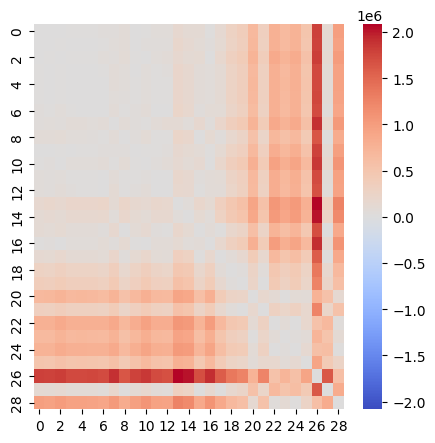

********************************* PM_LI CARGA *********************************


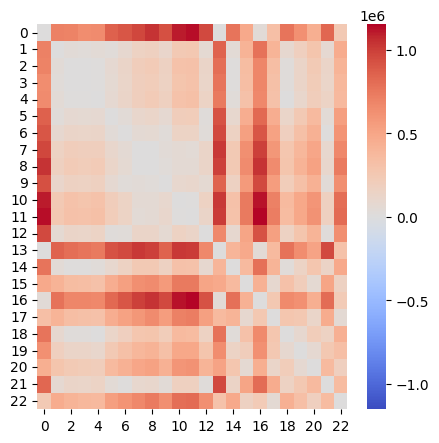

********************************* PM_TE CARGA *********************************


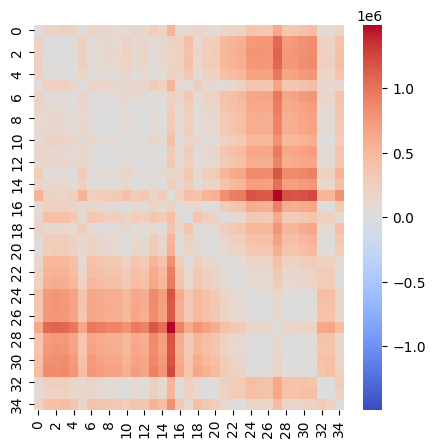

********************************* PM_LE CARGA *********************************


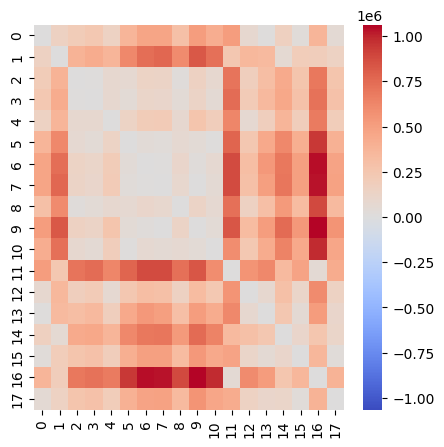

In [20]:
print("********************************* PM_TI CARGA *********************************")
buscaOutlayers(ids_PM_TI)
print("********************************* PM_LI CARGA *********************************")
buscaOutlayers(ids_PM_LI)
print("********************************* PM_TE CARGA *********************************")
buscaOutlayers(ids_PM_TE)
print("********************************* PM_LE CARGA *********************************")
buscaOutlayers(ids_PM_LE)


In [21]:
# Exportando datos
ids_PM_full = [ids_PM_TI, ids_PM_LI, ids_PM_TE, ids_PM_LE, ids_PM_nn]
# Archivo de los datos
nombrearchivo = "outputdata_m30_fulldates/m30_2024_data_fulldates_carga.txt"
datafile = open(nombrearchivo ,"w")
datafile.write(str(cantSensFinal)+" "+str(numFechas)+"\n")
for ids in ids_PM_full:
    for s in ids:
        datafile.write(str(s)+" ")
datafile.write("\n")
for ids in ids_PM_full:
    for s in ids:
        pos = dicc_posID[s]
        for c in range(numFechas):
            datafile.write(str(int(grillaCarga[pos][c]))+" ")
        datafile.write("\n")
datafile.close()
print("Archivo", nombrearchivo, "escrito correctamente.")

Archivo outputdata_m30_fulldates/m30_2024_data_fulldates_carga.txt escrito correctamente.


In [22]:
def exportarArchivoVecinos(diccVecinos, nombrearchivo):
    neigborfile = open(nombrearchivo,"w")
    neigborfile.write(str(len(diccVecinos))+"\n")
    for s in diccVecinos:
        neigborfile.write(str(s)+" ")
    neigborfile.write("\n")
    for s in diccVecinos:
        neigborfile.write(str(s) + " ")
        vec = diccVecinos[s]
        neigborfile.write(str(len(vec)))
        for v in vec:
            neigborfile.write(" " + str(v))
        neigborfile.write("\n")
    neigborfile.close()
    print("Archivo", nombrearchivo, "escrito correctamente.")

In [23]:
# Archivo para la construcción de la estructura
nombrearchivo = "outputdata_m30_fulldates/m30_2024_ids_estructura_carga.txt"
archivo = open(nombrearchivo,"w")
for ids in ids_PM_full:
    archivo.write(str(len(ids))+" ")
archivo.write("\n")
for ids in ids_PM_full:
    for ide in ids:
        archivo.write(str(ide)+" ")
    archivo.write("\n")
archivo.close()
print("Archivo", nombrearchivo, "escrito correctamente.")

Archivo outputdata_m30_fulldates/m30_2024_ids_estructura_carga.txt escrito correctamente.


In [24]:
# Archivo de lista de vecindad
nombrearchivo = "outputdata_m30_fulldates/m30_2024_listaVecindad_carga.txt"
archivo = open(nombrearchivo,"w")
archivo.write(str(len(list_Cods_final)) + "\n")
for ids in ids_PM_full:
    for ide in ids:
        archivo.write(str(ide)+" ")
archivo.write("\n")
for ids in ids_PM_full:
    tope = len(ids)
    for i in range(tope):
        archivo.write(str(ids[i]) + " 1 " + str(ids[i-1]) + "\n")
archivo.close()
print("Archivo", nombrearchivo, "escrito correctamente.")

Archivo outputdata_m30_fulldates/m30_2024_listaVecindad_carga.txt escrito correctamente.


In [25]:
ids_PM_nn_SinOutlayers = ids_PM_nn.copy()
# Troncal Interior - Se elimina el 7013
ids_PM_TI_SinOutlayers = [6641, 6642, 6644, 6648, 6650, 6654, 10175, 3799, 6666, 3491, 3816, 6672, 6679, 6680, 6683, 6685, 6687, 6689, 6691, 6693, 6694, 6695, 6698, 6699, 6700, 3801, 6706]
ids_PM_nn_SinOutlayers.append(7013)
# Lateral Interior - Se eliminan sobre 1e9: [3819, 3490]
ids_PM_LI_SinOutlayers = [6643, 6645, 6647, 6649, 6651, 6655, 10265, 3800, 3488, 3492, 6670, 6673, 6677, 6681, 7125, 6813, 10180, 6815, 6817, 7130, 7014]
ids_PM_nn_SinOutlayers += [3819, 3490]
# Troncal Exterior - Se eliminan sobre 0.8e9: [3823, 6715, 3598, 3494, 6758, 6725]
ids_PM_TE_SinOutlayers = [6713, 6717, 6720, 6722, 6729, 6732, 6734, 6737, 6743, 6746, 6749, 6753, 6763, 6765, 3532, 3533, 6766, 6768, 3836, 3558, 6769, 3597, 6770, 3599, 3560, 6771, 6772, 6775, 6934]
ids_PM_nn_SinOutlayers += [3823, 6715, 3598, 3494, 6758, 6725]
# Lateral Exterior - Se eliminan sobre 0.5e8: [6738, 6948]
ids_PM_LE_SinOutlayers = [6714, 6716, 6723, 6726, 6730, 6735, 6739, 6744, 6750, 10179, 6754, 6761, 3559, 6697, 6816, 6935]
ids_PM_nn_SinOutlayers += [6738, 6948]
ids_PM_full_SinOutlayers = [ids_PM_TI_SinOutlayers, ids_PM_LI_SinOutlayers, ids_PM_TE_SinOutlayers, ids_PM_LE_SinOutlayers, ids_PM_nn_SinOutlayers]

In [26]:
# Archivo para la construcción de la estructura
nombrearchivo = "outputdata_m30_fulldates/m30_2024_ids_estructura_sinOutlayers_carga.txt"
archivo = open(nombrearchivo,"w")
for ids in ids_PM_full_SinOutlayers:
    archivo.write(str(len(ids))+" ")
archivo.write("\n")
for ids in ids_PM_full_SinOutlayers:
    for ide in ids:
        archivo.write(str(ide)+" ")
    archivo.write("\n")
archivo.close()
print("Archivo", nombrearchivo, "escrito correctamente.")

Archivo outputdata_m30_fulldates/m30_2024_ids_estructura_sinOutlayers_carga.txt escrito correctamente.


In [27]:
# Archivo de lista de vecindad
nombrearchivo = "outputdata_m30_fulldates/m30_2024_listaVecindad_SinOutlayers_carga.txt"
archivo = open(nombrearchivo,"w")
archivo.write(str(len(list_Cods_final)) + "\n")
for ids in ids_PM_full_SinOutlayers:
    for ide in ids:
        archivo.write(str(ide)+" ")
archivo.write("\n")
for ids in ids_PM_full_SinOutlayers:
    tope = len(ids)
    for i in range(tope):
        archivo.write(str(ids[i]) + " 1 " + str(ids[i-1]) + "\n")
archivo.close()
print("Archivo", nombrearchivo, "escrito correctamente.")

Archivo outputdata_m30_fulldates/m30_2024_listaVecindad_SinOutlayers_carga.txt escrito correctamente.


In [28]:
# Calculando valores vs Diferencia con semana promedio por grupo
dicc_histograma_original = {}
dicc_histograma_diff_semana = {}
times_x_semana = 7 * 24 * 4
numSemanas = numFechas / times_x_semana
for lx in ids_PM_full_SinOutlayers:
    tope = len(lx)
    semana = np.zeros(times_x_semana)
    for i in range(tope):
        ids = lx[i]
        pos = dicc_posID[ids]
        for j in range(numFechas):
            val = grillaCarga[pos][j]
            semana[j % times_x_semana] += val
            if val not in dicc_histograma_original:
                dicc_histograma_original[val] = 1
            else:
                dicc_histograma_original[val] += 1
    for i in range(times_x_semana):
        semana[i] = int(semana[i] / numSemanas / len(lx))
    for i in range(tope):
        ids = lx[i]
        pos = dicc_posID[ids]
        for j in range(numFechas):
            val = grillaCarga[pos][j] - semana[j % times_x_semana]            
            if val not in dicc_histograma_diff_semana:
                dicc_histograma_diff_semana[val] = 1
            else:
                dicc_histograma_diff_semana[val] += 1

In [29]:
cants_original = list(dicc_histograma_original.keys())
cants_semana = list(dicc_histograma_diff_semana.keys())
cants_original.sort()
cants_semana.sort()

In [30]:
# Prueba para promedio de una semana para un sensor:
dicc_Or = {}
dicc_Pr = {}
semana = np.zeros(times_x_semana)
pos = dicc_posID[ids_PM_TI[0]]
sx = grillaCarga[pos]
print("len sx:", len(sx))
for i in range(len(sx)):
    if sx[i] not in dicc_Or:
        dicc_Or[sx[i]] = 1
    else:
        dicc_Or[sx[i]] += 1
    porcion = sx[i] / numSemanas
    semana[i % times_x_semana] += porcion
for i in range(times_x_semana):
    semana[i] = int(semana[i])
for i in range(len(sx)):
    val = sx[i] - semana[i % times_x_semana]            
    if val not in dicc_Pr:
        dicc_Pr[val] = 1
    else:
        dicc_Pr[val] += 1
cOr = list(dicc_Or.keys())
cOr.sort()
cPr = list(dicc_Pr.keys())
cPr.sort()
print("Prueba OR:", cOr[0], cOr[-1])
print("Prueba PR:", cPr[0], cPr[-1])

len sx: 35136
Prueba OR: 0 100
Prueba PR: -86.0 56.0


In [31]:
# Método de un promedio por sensor
dicc_histograma_diff_semana_1xsen = {}
for lx in ids_PM_full_SinOutlayers:
    for idx in lx:
        semana = np.zeros(times_x_semana)
        pos = dicc_posID[idx]
        sx = grillaCarga[pos]
        for i in range(len(sx)):
            porcion = sx[i] / numSemanas
            semana[i % times_x_semana] += porcion
        for i in range(times_x_semana):
            semana[i] = int(semana[i])
        for i in range(len(sx)):
            val = sx[i] - semana[i % times_x_semana]            
            if val not in dicc_histograma_diff_semana_1xsen:
                dicc_histograma_diff_semana_1xsen[val] = 1
            else:
                dicc_histograma_diff_semana_1xsen[val] += 1
cants_1xsemana = list(dicc_histograma_diff_semana_1xsen.keys())
cants_1xsemana.sort()

In [32]:
print("------ Rangos ------")
print("Original:\t", cants_original[0], "\t", cants_original[-1])
print("Metodo semana:\t", cants_semana[0], "\t", cants_semana[-1])
print("1 x sensor:\t", cants_1xsemana[0], "\t", cants_1xsemana[-1])


------ Rangos ------
Original:	 0 	 100
Metodo semana:	 -79.0 	 97.0
1 x sensor:	 -94.0 	 98.0


In [33]:
histomin = min(min(int(cants_original[0]), int(cants_semana[0])), int(cants_1xsemana[0]))
histomax = max(max(int(cants_original[-1]), int(cants_semana[-1])), int(cants_1xsemana[-1]))
dataOriginal = []
dataXsemana = []
dataSsensor = []
ejex = []
for i in range(histomin, histomax+1):
    ejex.append(i)
    if i in dicc_histograma_original:
        dataOriginal.append(dicc_histograma_original[i])
    else:
        dataOriginal.append(0)
    if i in dicc_histograma_diff_semana:
        dataXsemana.append(dicc_histograma_diff_semana[i])
    else:
        dataXsemana.append(0)
    if i in dicc_histograma_diff_semana_1xsen:
        dataSsensor.append(dicc_histograma_diff_semana_1xsen[i])
    else:
        dataSsensor.append(0)



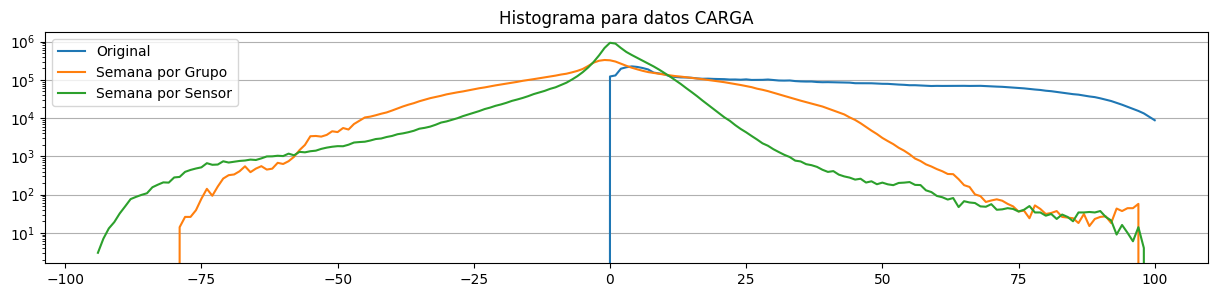

In [34]:
plt.figure(figsize=(15,3))
plt.plot(ejex, dataOriginal, label='Original')
plt.plot(ejex, dataXsemana, label='Semana por Grupo')
plt.plot(ejex, dataSsensor, label='Semana por Sensor')
plt.title("Histograma para datos CARGA")
#plt.savefig('histograma_2024_vecinos_x_distancia.png', bbox_inches='tight')
plt.grid(axis='y')
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

In [35]:
def plotSerie(idSerie):
    ps = dicc_posID[idSerie]
    if idSerie not in dicc_posID:
        print("ID " + str(idSerie) + " no encontrado")
        return
    plt.figure(figsize=(15,3))
    plt.plot(grillaCargaOriginal[ps], label="Original")
    plt.plot(grillaCarga[ps], label="Corregida")
    plt.title('Carga sensor '+str(idSerie))
    #plt.savefig('histograma_2024_vecinos_x_distancia.png', bbox_inches='tight')
    plt.grid(axis='y')
    #plt.yscale('log')
    plt.legend()
    plt.show()
    plt.close()

In [36]:
ticks = []
for i in range(8):
    ticks.append(i*24*4)

def plotPrimeraSemana(IDsSemana):
    plt.figure(figsize=(15,3))
    for i in IDsSemana:
        ps = dicc_posID[i]
        if i not in dicc_posID:
            print("ID " + str(i) + " no encontrado")
        plt.plot(grillaCarga[ps][:times_x_semana], label=str(i))
    plt.title('Carga 1a Semana')
    #plt.savefig('histograma_2024_vecinos_x_distancia.png', bbox_inches='tight')
    plt.grid(axis='y')
    #plt.yscale('log')
    plt.xticks(ticks)
    plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
    plt.show()
    plt.close()

def plotSegundaSemana(IDsSemana):
    plt.figure(figsize=(15,3))
    for i in IDsSemana:
        ps = dicc_posID[i]
        if i not in dicc_posID:
            print("ID " + str(i) + " no encontrado")
        plt.plot(grillaCarga[ps][times_x_semana:2*times_x_semana], label=str(i))
    plt.title('Carga 2a Semana')
    #plt.savefig('histograma_2024_vecinos_x_distancia.png', bbox_inches='tight')
    plt.grid(axis='y')
    #plt.yscale('log')
    plt.xticks(ticks)
    plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
    plt.show()
    plt.close()

def plotUltimaSemana(IDsSemana):
    timesAux = numFechas - times_x_semana
    tit = "Histograma Comparación para Datos Originales vs Promedio + Factor (Ocupación)"
    plt.figure(figsize=(15,3))
    for i in IDsSemana:
        ps = dicc_posID[i]
        if i not in dicc_posID:
            print("ID " + str(i) + " no encontrado")
        plt.plot(grillaCarga[ps][timesAux:], label=str(i))
    plt.title('Carga Última Semana')
    #plt.savefig('histograma_2024_vecinos_x_distancia.png', bbox_inches='tight')
    plt.grid(axis='y')
    #plt.yscale('log')
    plt.xticks(ticks)
    plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
    plt.show()
    plt.close()

In [37]:
def estadisticasLista(listaIDs):
    acumTotal = 0
    for ids in listaIDs:
        acumLista = 0
        ps = dicc_posID[ids]
        for x in grillaCarga[ps]:
            acumLista += x
        acumTotal += float(acumLista) / numFechas
    minimo = x
    maximo = x
    promedioTotal = acumTotal / len(listaIDs)
    sumatoria = 0
    for ids in listaIDs:
        ps = dicc_posID[ids]
        minimo = min(minimo, min(grillaCarga[ps]))
        maximo = max(maximo, max(grillaCarga[ps]))
        for x in grillaCarga[ps]:
            diferencia = x - promedioTotal
            sumatoria += (diferencia * diferencia)
    varianza = sumatoria / (len(listaIDs) * numFechas)
    desviacion = math.sqrt(varianza)
    print("Mínimo:", minimo)
    print("Máximo:", maximo)
    print("Promedio:", round(promedioTotal,2))
    print("Varianza:", round(varianza,2))
    print("Desviación estándar:", round(desviacion,2))

In [38]:
print("********************************* Estadísticas PM_TI CARGA *********************************")
estadisticasLista(ids_PM_TI)
print("********************************* Estadísticas PM_LI CARGA *********************************")
estadisticasLista(ids_PM_LI)
print("********************************* Estadísticas PM_TE CARGA *********************************")
estadisticasLista(ids_PM_TE)
print("********************************* Estadísticas PM_LE CARGA *********************************")
estadisticasLista(ids_PM_LE)
print("********************************* Estadísticas PM_NN CARGA *********************************")
estadisticasLista(ids_PM_nn)
print("********************************* Estadísticas TODOS CARGA *********************************")
estadisticasLista(list_IDs_final)

********************************* Estadísticas PM_TI CARGA *********************************
Mínimo: 0
Máximo: 100
Promedio: 41.0
Varianza: 935.39
Desviación estándar: 30.58
********************************* Estadísticas PM_LI CARGA *********************************
Mínimo: 0
Máximo: 100
Promedio: 40.96
Varianza: 824.6
Desviación estándar: 28.72
********************************* Estadísticas PM_TE CARGA *********************************
Mínimo: 0
Máximo: 100
Promedio: 39.16
Varianza: 763.88
Desviación estándar: 27.64
********************************* Estadísticas PM_LE CARGA *********************************
Mínimo: 0
Máximo: 100
Promedio: 43.43
Varianza: 796.38
Desviación estándar: 28.22
********************************* Estadísticas PM_NN CARGA *********************************
Mínimo: 0
Máximo: 100
Promedio: 32.68
Varianza: 604.76
Desviación estándar: 24.59
********************************* Estadísticas TODOS CARGA *********************************
Mínimo: 0
Máximo: 100
Promedio: 36

In [39]:
def estadisticasListaValores(listaValores):
    acumulado = 0
    for x in listaValores:
        acumulado += x
    promedio = float(acumulado) / len(listaValores)
    sumatoria = 0
    for x in listaValores:
        diferencia = x - promedio
        sumatoria += (diferencia * diferencia)
    varianza = sumatoria / len(listaValores)
    desviacion = math.sqrt(varianza)
    print("Mínimo:", min(listaValores))
    print("Máximo:", max(listaValores))
    print("Promedio:", round(promedio,2))
    print("Varianza:", round(varianza,2))
    print("Desviación estándar:", round(desviacion,2))

In [40]:
def estadisticasHistograma(listaValores):
    acumulado = 0
    minimo = histomax
    maximo = histomin
    valor = histomin
    cantidad = 0
    for x in listaValores:
        if x > 0:
            acumulado += (x * valor)
            cantidad += x
            minimo = min(minimo, valor)
            maximo = max(maximo, valor)
        valor += 1
    promedio = float(acumulado) / cantidad
    sumatoria = 0
    valor = histomin
    for x in listaValores:
        diferencia = valor - promedio
        sumatoria += (diferencia * diferencia * x)
        valor += 1
    varianza = sumatoria / cantidad
    desviacion = math.sqrt(varianza)
    print("Mínimo:", minimo)
    print("Máximo:", maximo)
    print("Promedio:", round(promedio,2))
    print("Varianza:", round(varianza,2))
    print("Desviación estándar:", round(desviacion,2))

In [41]:
print(" *************************** Estadísticas Histograma CARGA datos Originales ***************************")
estadisticasHistograma(dataOriginal)
print(" *************************** Estadísticas Histograma CARGA datos Semana por grupo ***************************")
estadisticasHistograma(dataXsemana)
print(" *************************** Estadísticas Histograma CARGA datos Semana por sensor ***************************")
estadisticasHistograma(dataSsensor)

 *************************** Estadísticas Histograma CARGA datos Originales ***************************
Mínimo: 0
Máximo: 100
Promedio: 36.37
Varianza: 717.54
Desviación estándar: 26.79
 *************************** Estadísticas Histograma CARGA datos Semana por grupo ***************************
Mínimo: -79
Máximo: 97
Promedio: 0.49
Varianza: 300.83
Desviación estándar: 17.34
 *************************** Estadísticas Histograma CARGA datos Semana por sensor ***************************
Mínimo: -94
Máximo: 98
Promedio: 0.49
Varianza: 80.74
Desviación estándar: 8.99


In [42]:
def plotHistograma(listaDiccValores, listaTitulos, tituloGrafica):
    arrMin = []
    arrMax = []
    for i in listaDiccValores:
        v = list(i.keys())
        arrMin.append(min(v))
        arrMax.append(max(v))
    print("Valores minimos:", arrMin)
    print("Valores máximos:", arrMax)
    minmin = min(arrMin)
    maxmax = max(arrMax)
    plt.figure(figsize=(15,3))
    ejex = []
    for i in range(minmin, maxmax+1):
        ejex.append(i)
    for d in range(len(listaDiccValores)):
        valores = []
        for i in range(minmin, maxmax+1):
            if i in listaDiccValores[d]:
                valores.append(listaDiccValores[d][i])
            else:
                valores.append(0)
        plt.plot(ejex, valores, label=listaTitulos[d])
    plt.title("Histograma para datos Carga")
    #plt.savefig('histograma_2024_vecinos_x_distancia.png', bbox_inches='tight')
    plt.grid(axis='y')
    #plt.yscale('log')
    plt.legend()
    plt.show()
    plt.close()

In [43]:
def diccionarioHistoDeLista(lista):
    diccHisto = {}
    for x in lista:
        if x in diccHisto:
            diccHisto[x] += 1
        else:
            diccHisto[x] = 1
    return diccHisto

In [44]:
def diccionarioHistogramaPorID(idSensor):
    if idSensor not in dicc_posID:
        return {}
    ps = dicc_posID[idSensor]
    return diccionarioHistoDeLista(grillaCarga[ps])

In [45]:
def graficaPromedioBloquesPorSerie(listaIDs, numSeriesGrafica, numBloquesGrafica):
    if len(listaIDs) < numSeriesGrafica:
        numSeriesGrafica = len(listaIDs)
    promedio_horas = []
    for ids in listaIDs[:numSeriesGrafica]:
        ph = np.zeros(numBloquesGrafica)
        ps = dicc_posID[ids]
        for p in range(numFechas):
            ph[p%numBloquesGrafica] += grillaCarga[ps][p]
        muestrasXhora = numFechas/numBloquesGrafica
        for p in range(numBloquesGrafica):
            ph[p] = ph[p] / muestrasXhora
        promedio_horas.append(ph)
    plt.figure(figsize=(15,3))
    for s in range(numSeriesGrafica):
        plt.plot(promedio_horas[s], label=str(listaIDs[s]))
    plt.title('Promedio de Carga por '+str(numBloquesGrafica)+' bloques de 15m.')
    #plt.savefig('histograma_2024_vecinos_x_distancia.png', bbox_inches='tight')
    plt.grid(axis='y')
    #plt.yscale('log')
    ticks = range(numBloquesGrafica)
    #plt.xticks(ticks)
    plt.legend(loc='center right', bbox_to_anchor=(1.1, 0.5))
    plt.show()
    plt.close()

*********************************** Muestra para TI ***********************************


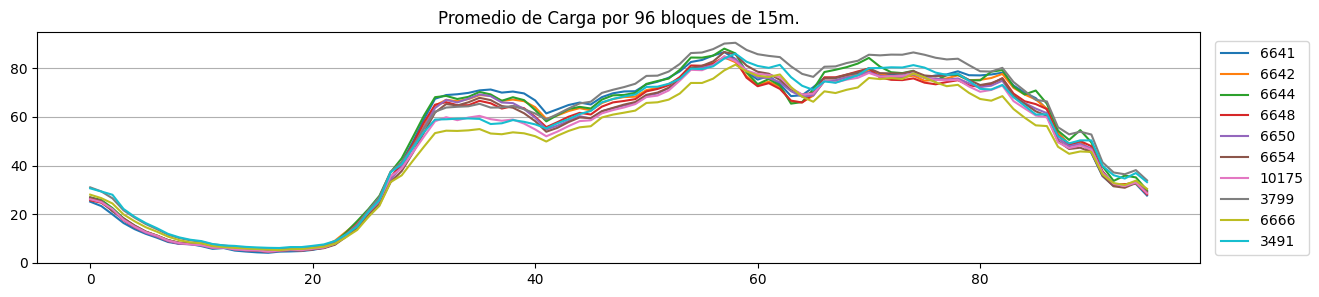

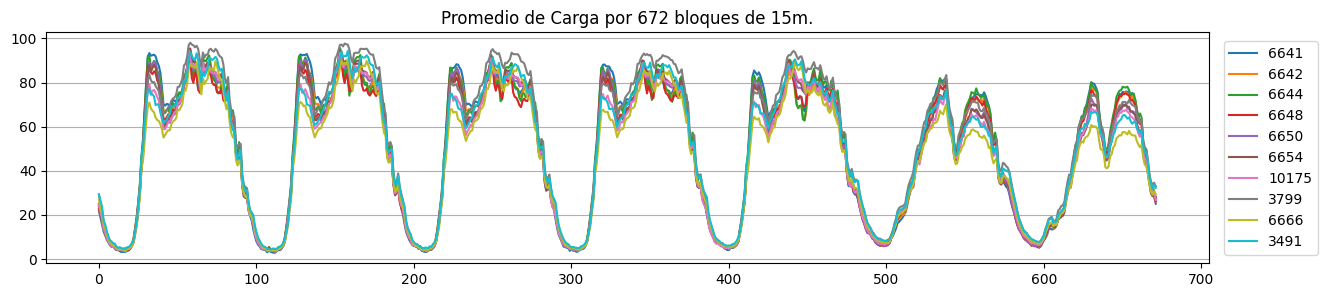

In [46]:
print("*********************************** Muestra para TI ***********************************")
graficaPromedioBloquesPorSerie(ids_PM_TI, 10, 96)
graficaPromedioBloquesPorSerie(ids_PM_TI, 10, 672)

*********************************** Muestra para TE ***********************************


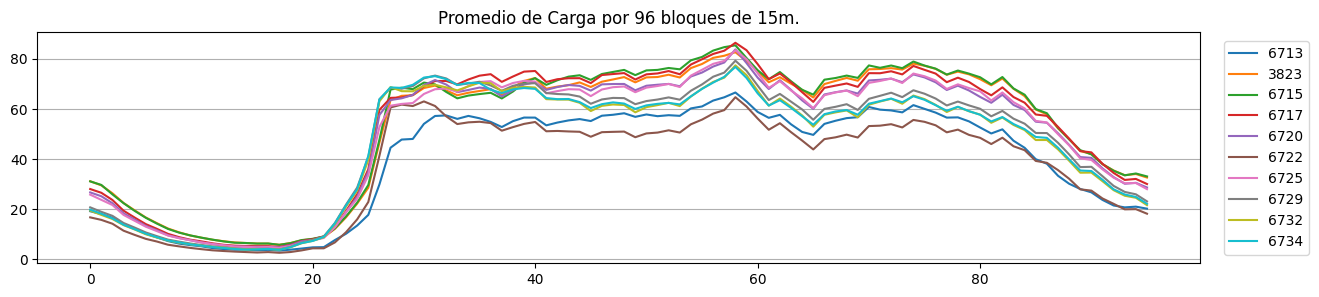

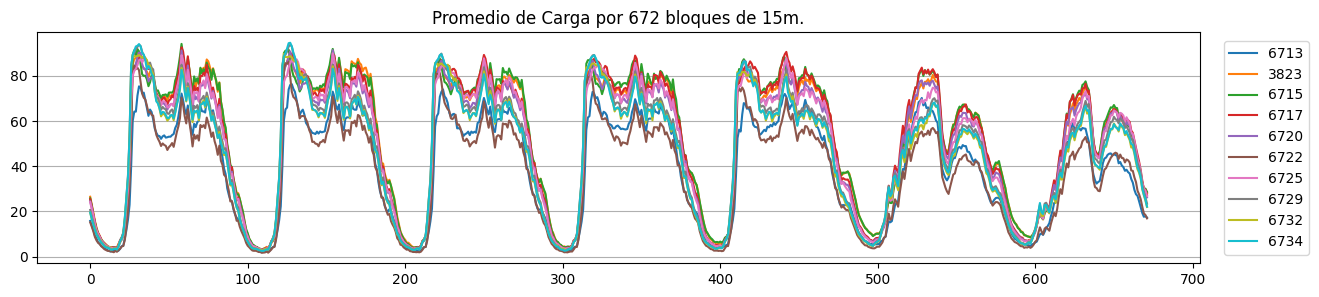

In [47]:
print("*********************************** Muestra para TE ***********************************")
graficaPromedioBloquesPorSerie(ids_PM_TE, 10, 96)
graficaPromedioBloquesPorSerie(ids_PM_TE, 10, 672)

*********************************** Muestra para LI ***********************************


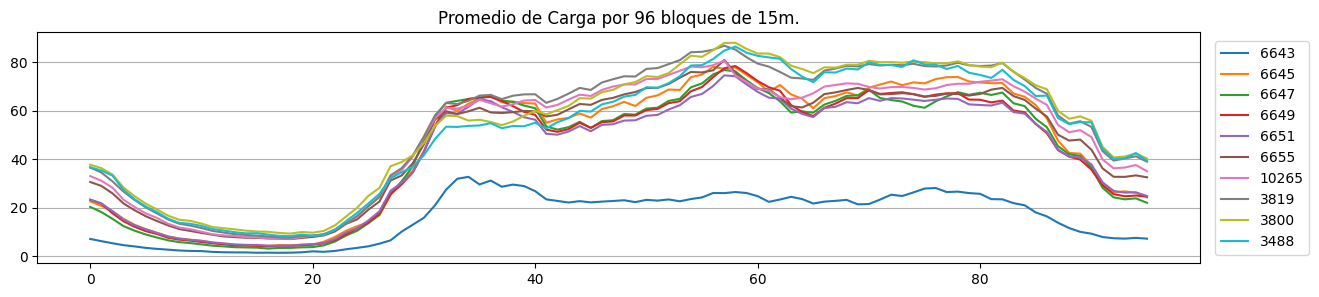

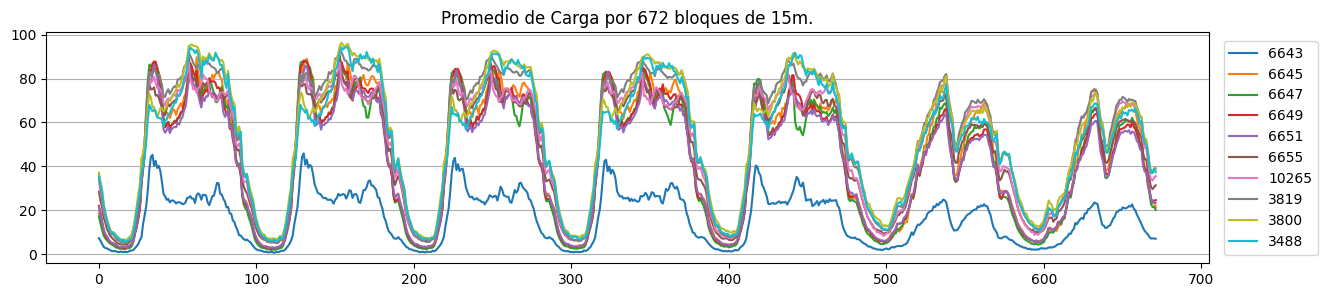

In [48]:
print("*********************************** Muestra para LI ***********************************")
graficaPromedioBloquesPorSerie(ids_PM_LI, 10, 96)
graficaPromedioBloquesPorSerie(ids_PM_LI, 10, 672)

*********************************** Muestra para LE ***********************************


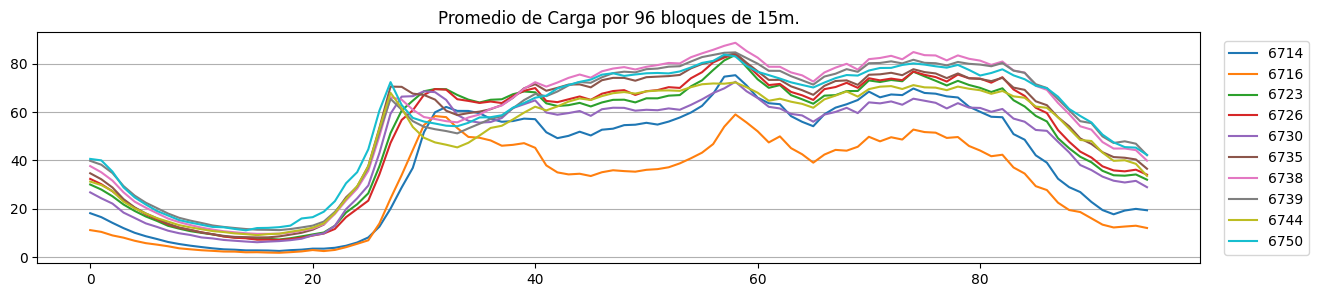

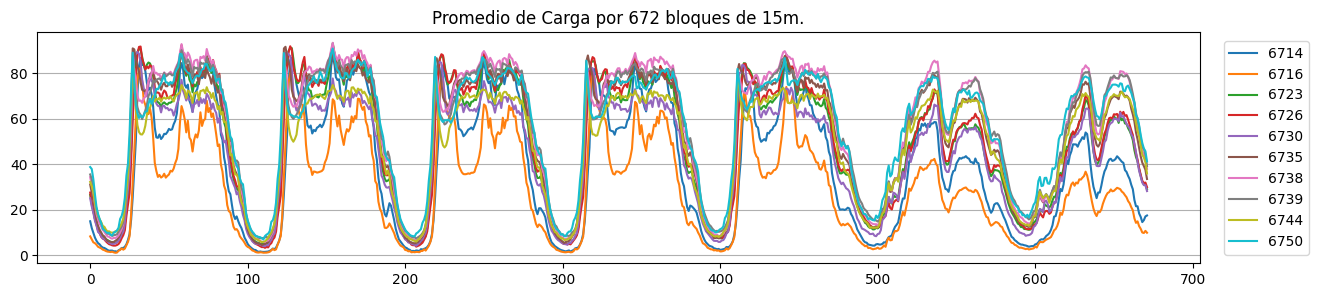

In [49]:
print("*********************************** Muestra para LE ***********************************")
graficaPromedioBloquesPorSerie(ids_PM_LE, 10, 96)
graficaPromedioBloquesPorSerie(ids_PM_LE, 10, 672)

*********************************** Muestra para nn ***********************************


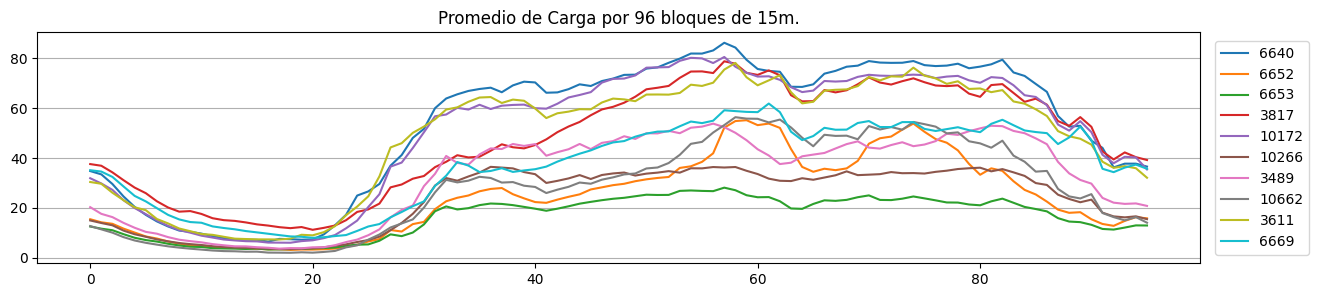

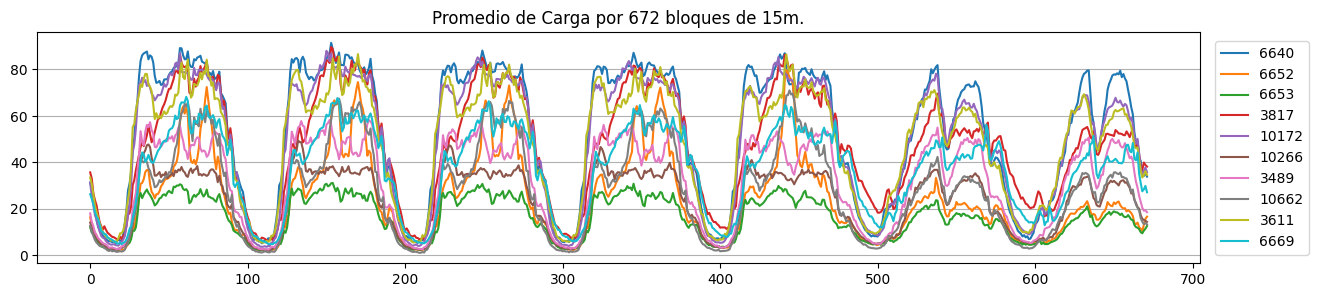

In [50]:
print("*********************************** Muestra para nn ***********************************")
graficaPromedioBloquesPorSerie(ids_PM_nn, 10, 96)
graficaPromedioBloquesPorSerie(ids_PM_nn, 10, 672)

In [51]:
def distanciaEuclideaSerie(listaA, listaB):
    if len(listaA) != len(listaB):
        print("Error! el largo de la lista no coincide.")
        return 'Error'
    sumatoria = 0
    n = len(listaA)
    for i in range(n):
        dif = listaA[i] - listaB[i]
        sumatoria += (dif * dif)
    distEucSerie = sumatoria / n
    return sumatoria

In [52]:
def matrizDistanciaEuclideaSerie(listaIDs, factor):
    numSeries = len(listaIDs)
    matriz = np.zeros((numSeries, numSeries))
    for i in range(numSeries):
        id1 = listaIDs[i]
        if id1 in dicc_posID:
            ps1 = dicc_posID[id1]
            for j in range(i+1, numSeries):
                id2 = listaIDs[j]
                if id2 in dicc_posID:
                    ps2 = dicc_posID[id2]
                    des = distanciaEuclideaSerie(grillaCarga[ps1], grillaCarga[ps2])
                    des /= factor
                    matriz[i][j] = des
                    matriz[j][i] = des
    for i in range(numSeries):
        print("\t"+str(listaIDs[i]), end="")
    print("")
    for i in range(numSeries):
        print(listaIDs[i], end="\t")
        for j in range(numSeries):
            print(round(matriz[i][j], 2), end="\t")
        print("")
    return matriz

In [53]:
m = matrizDistanciaEuclideaSerie(ids_PM_TI[:10], 100000)

	6641	6642	6644	6648	6650	6654	10175	3799	6666	3491
6641	0.0	12.35	6.82	9.81	16.26	15.02	22.44	24.75	40.13	29.72	
6642	12.35	0.0	13.58	14.82	21.52	19.47	25.18	33.12	39.9	33.64	
6644	6.82	13.58	0.0	6.76	16.72	15.21	20.42	23.48	40.14	29.33	
6648	9.81	14.82	6.76	0.0	14.83	13.22	15.11	27.49	29.64	25.78	
6650	16.26	21.52	16.72	14.83	0.0	10.63	16.29	26.63	27.08	26.76	
6654	15.02	19.47	15.21	13.22	10.63	0.0	10.6	20.3	21.67	21.78	
10175	22.44	25.18	20.42	15.11	16.29	10.6	0.0	19.62	11.79	14.83	
3799	24.75	33.12	23.48	27.49	26.63	20.3	19.62	0.0	28.36	15.74	
6666	40.13	39.9	40.14	29.64	27.08	21.67	11.79	28.36	0.0	13.38	
3491	29.72	33.64	29.33	25.78	26.76	21.78	14.83	15.74	13.38	0.0	


In [54]:
m = matrizDistanciaEuclideaSerie(list_IDs_final, 100000)

	6640	6641	6642	6643	6644	6645	6647	6648	6649	6650	6651	6652	6653	6654	6655	10175	10265	3817	3819	10172	10266	3799	3800	6666	3488	3489	10662	3611	6669	6668	3490	3491	3492	3493	3816	6670	6671	6672	6673	6674	7124	6677	6678	6679	6680	6681	6682	6683	6684	6685	6686	6687	6688	6689	10660	6691	7125	6693	6694	6813	6695	10659	10180	6698	6815	6817	6699	6700	3801	6702	6706	6707	7130	7013	7014	6713	3821	3822	3823	6714	6715	6716	6717	6719	6720	6722	6723	6725	6726	6729	6730	6731	6732	10661	6734	6735	6736	10194	6737	6738	6739	6740	6742	6741	10267	6743	6744	6745	6746	7126	6748	10177	6749	6750	10179	10178	6753	6754	6755	6757	6758	6759	6760	6761	6763	6764	6765	3531	3532	3533	6948	6766	6768	3836	3558	3559	6769	6697	3597	6816	6770	3598	3599	3560	6771	3494	6772	6774	6775	6934	6935	3521	6712	3837	3539	3536	6819	3495	3561	6667	3600	3838	3839	6777	7127	6778	6779	6822	6780	6938	6939	6942	6941	6949	6950	6781	6782	3496	6783	6784	6785	6932	7128	3797	10198	10200	10201	10199	3538	6789	10176	6661	6790	7131	3827	3828	

6702 6755 7126 6950


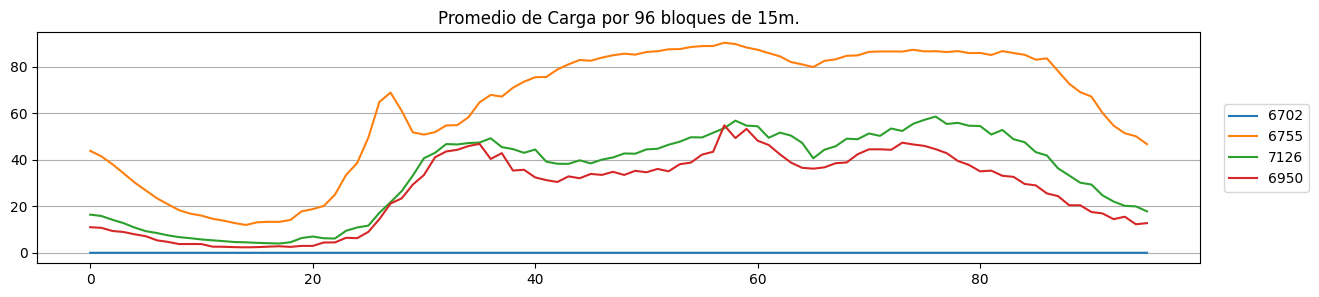

In [55]:
maxmatriz = m[0][1]
fmax = [0]
cmax = [1]
for f in range(len(m)):
    for c in range(len(m[f])):
        if m[f][c] > maxmatriz:
            maxmatriz = m[f][c]
            fmax = f
            cmax = c
idF = list_IDs_final[fmax]
idC = list_IDs_final[cmax]
distF = m[fmax].copy()
distF.sort()
vft = distF[0] + ((distF[-1] - distF[0])/3)
i = 0
while distF[i] < vft:
    i+=1
vft = distF[i]
ftercio = 0
while ftercio < len(m) and m[fmax][ftercio] != vft:
    ftercio+=1
idFM = list_IDs_final[ftercio]
distC = m[cmax].copy()
distC.sort()
vct = distC[0] + ((distC[-1] - distC[0])/3)
i = 0
while distC[i] < vct:
    i+=1
vct = distC[i]
ctercio = 0
while ctercio < len(m) and m[cmax][ctercio] != vct:
    ctercio+=1
idCM = list_IDs_final[ctercio]
print(idF, idC, idFM, idCM)
l = [idF, idC, idFM, idCM]
graficaPromedioBloquesPorSerie(l, 4, 96)

In [56]:
print(fmax, cmax, ftercio, ctercio)
print(list_IDs_final[fmax], list_IDs_final[cmax], list_IDs_final[ftercio], list_IDs_final[ctercio])
listA = []
listB = []
listC = []
listD = []
listasDES = [listA, listB, listC, listD]
listaPOS = [fmax, cmax, ftercio, ctercio]
print("max euc dist:", m[fmax][cmax])
for i in range(len(m)):
    minI = m[fmax][cmax]
    posMin = -1
    for j in range(len(listasDES)):
        if m[i][listaPOS[j]] < minI:
            minI = m[i][listaPOS[j]]
            posMin = j
    listasDES[posMin].append(list_IDs_final[i])
for lis in listasDES:
    print(len(lis))

69 118 109 174
6702 6755 7126 6950
max euc dist: 1677.67949
12
45
107
77


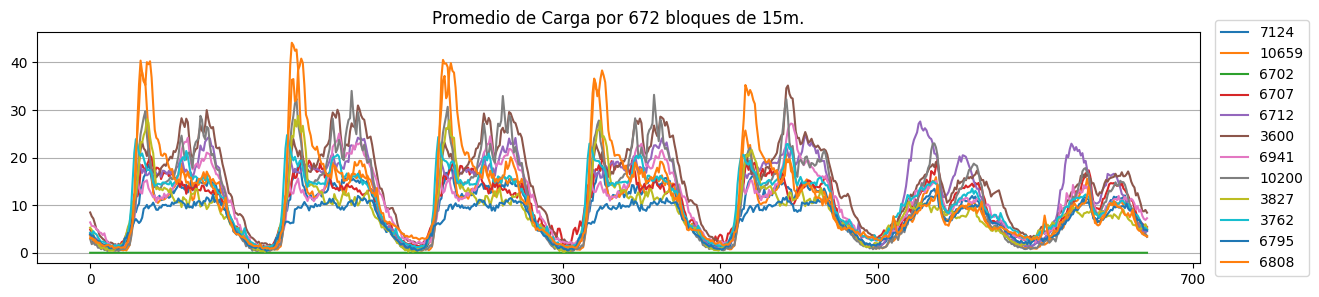

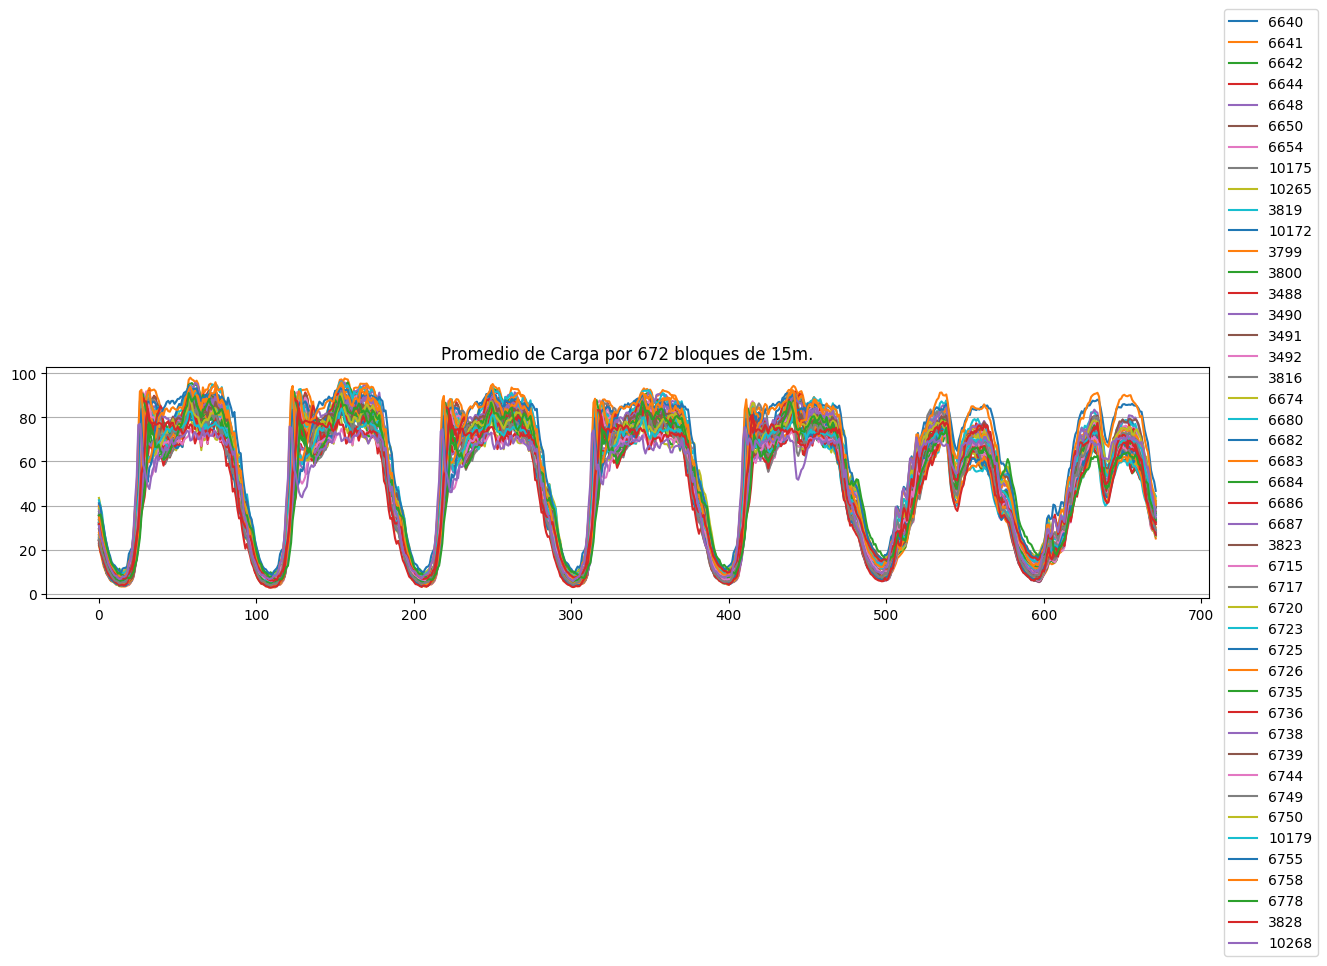

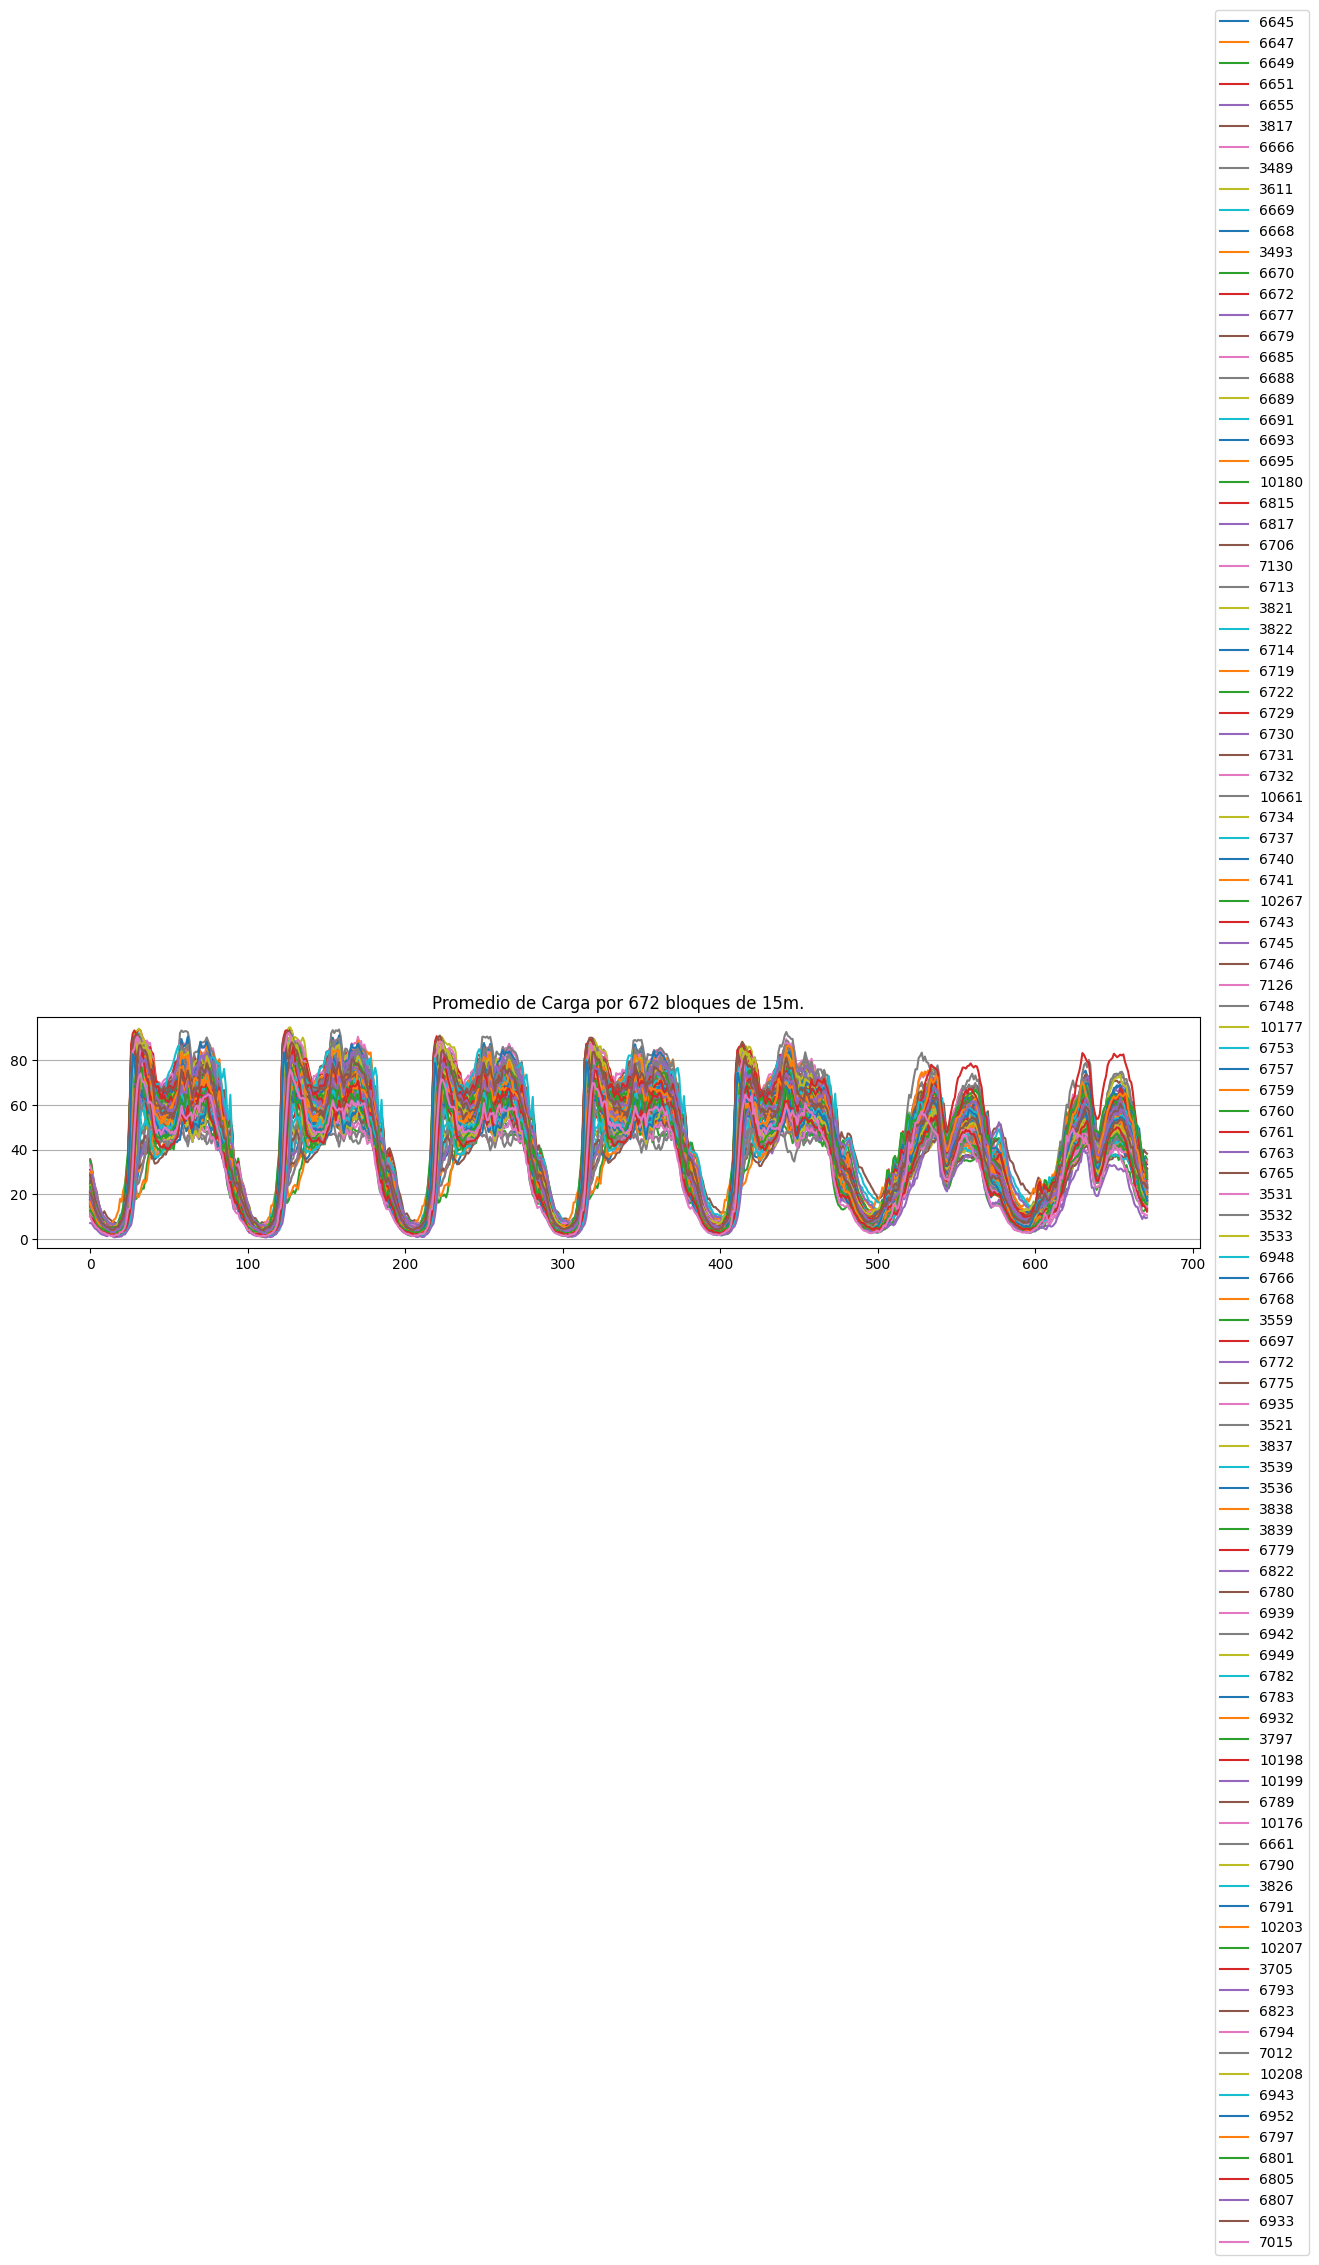

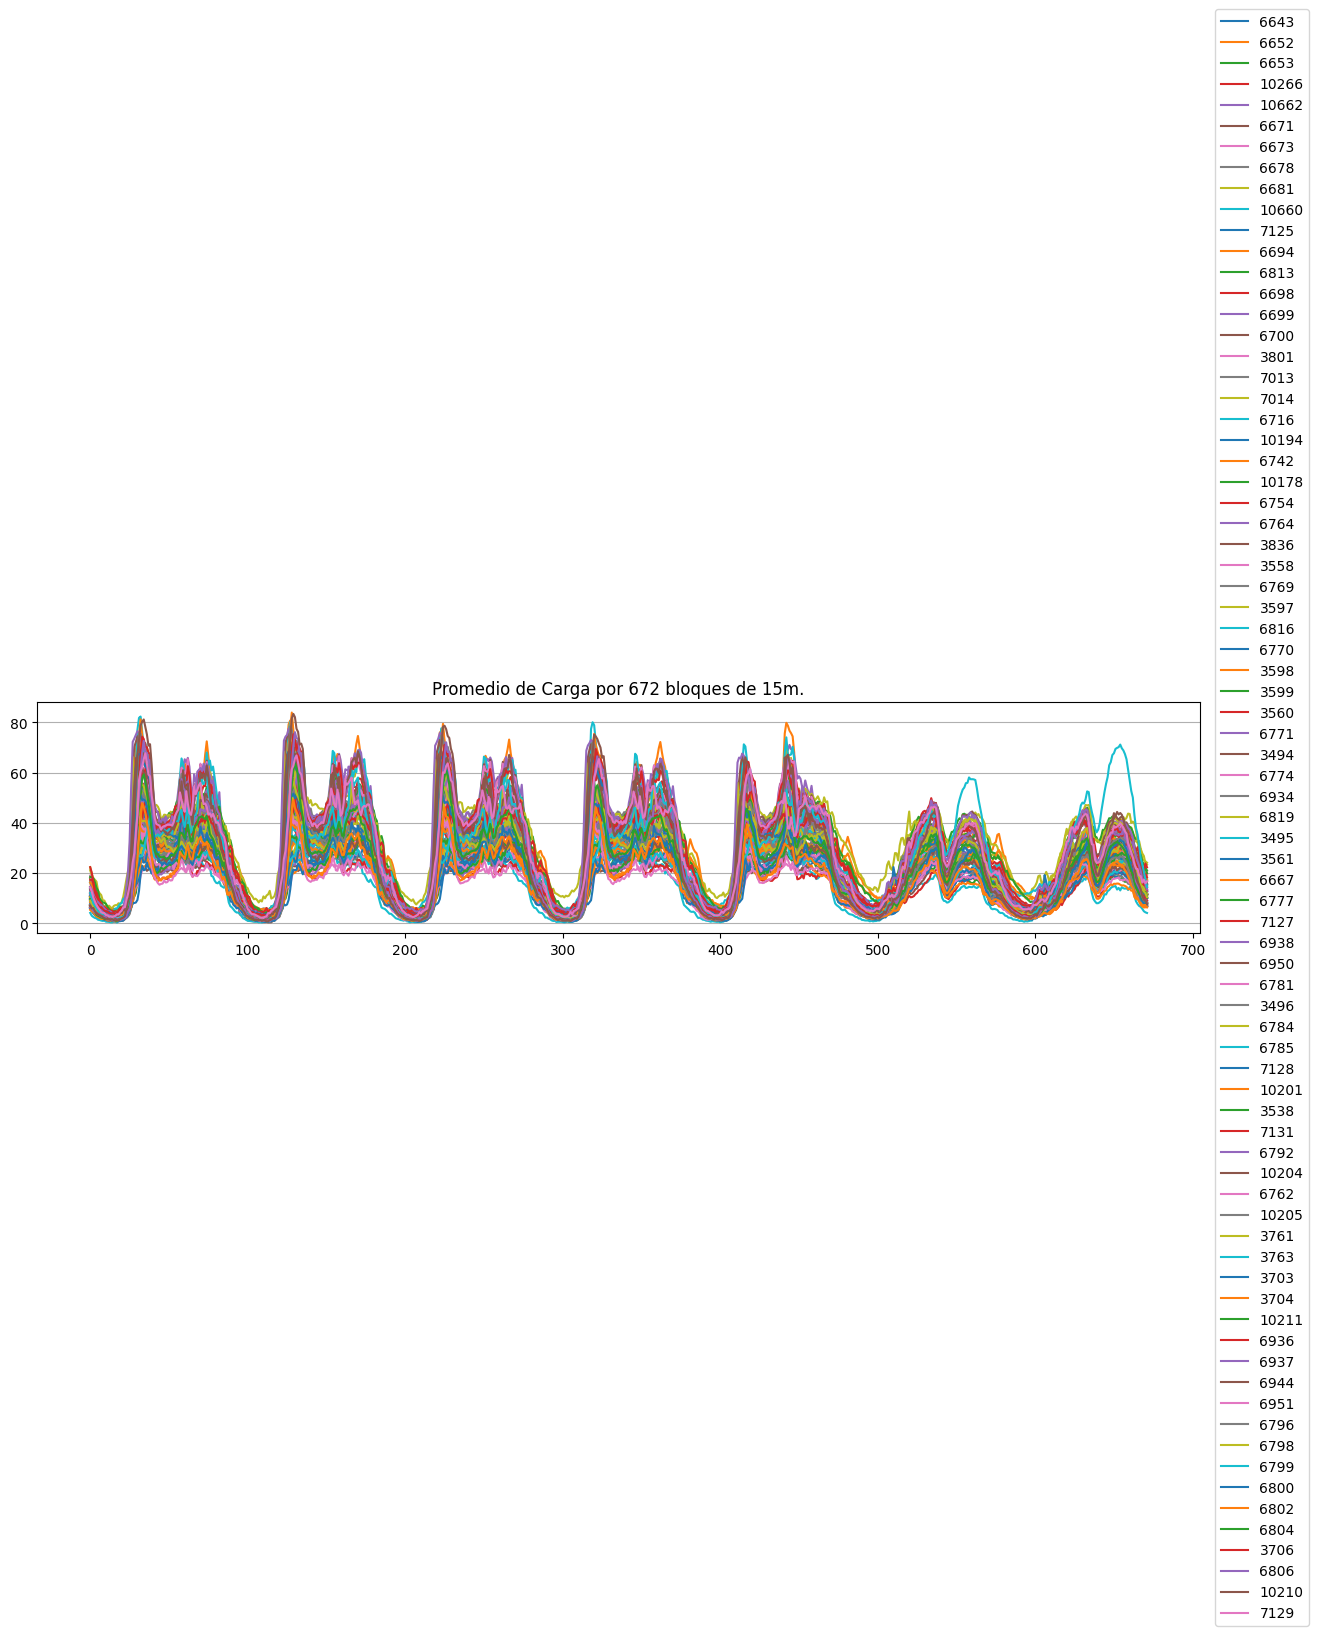

In [57]:
for lis in listasDES:
    graficaPromedioBloquesPorSerie(lis, len(lis), 672)

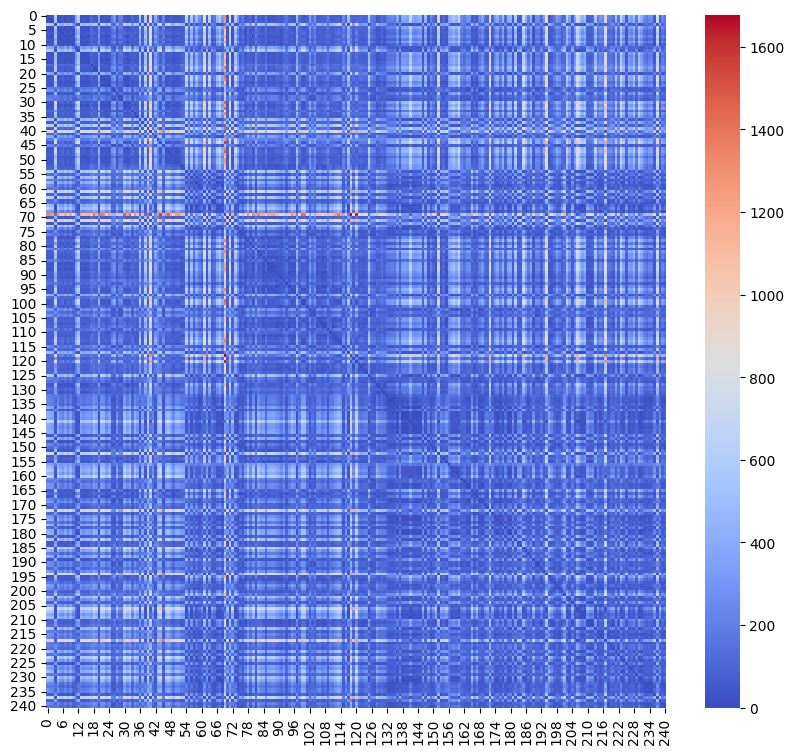

In [58]:
plt.figure(figsize=(10, 9))
#plt.axis('off')
heatmap = sns.heatmap(m, cmap=cmap)
#plt.savefig('image_filename.png', bbox_inches='tight')
plt.show()
plt.close()

241
48
240


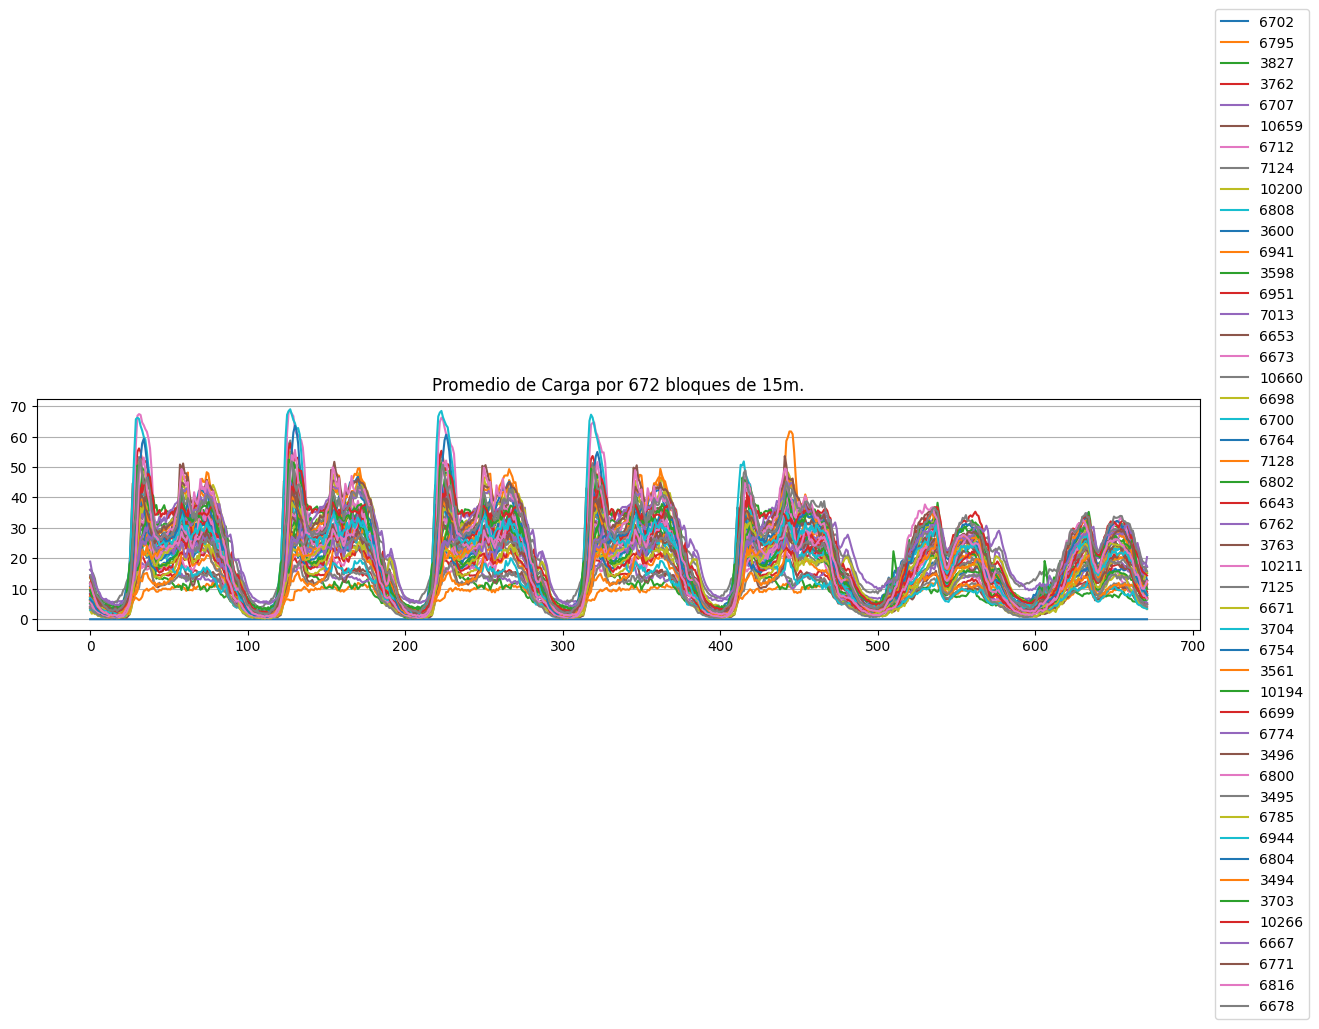

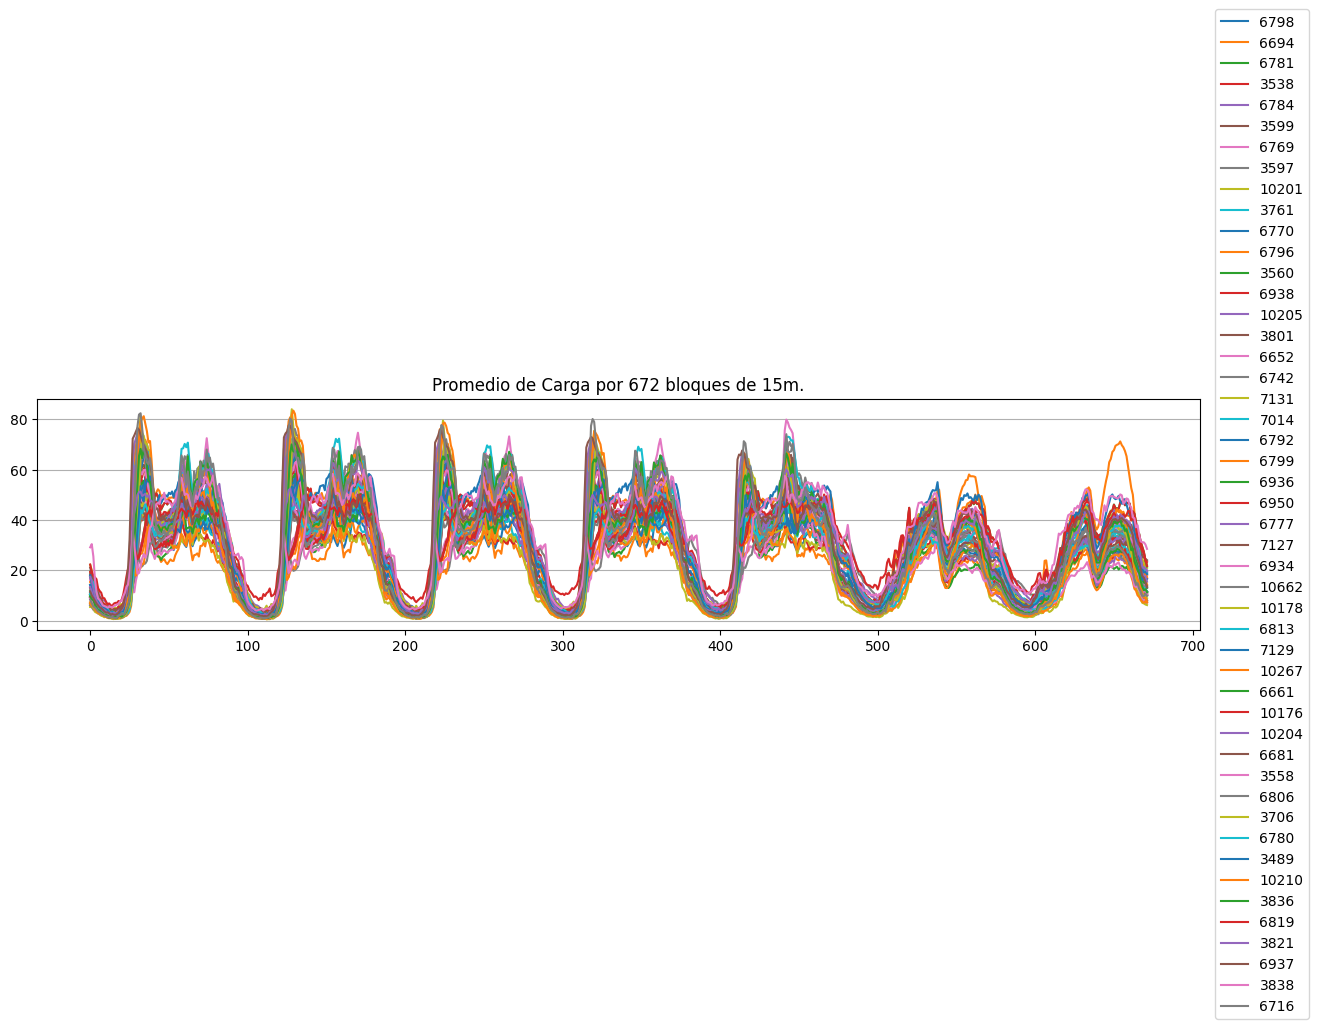

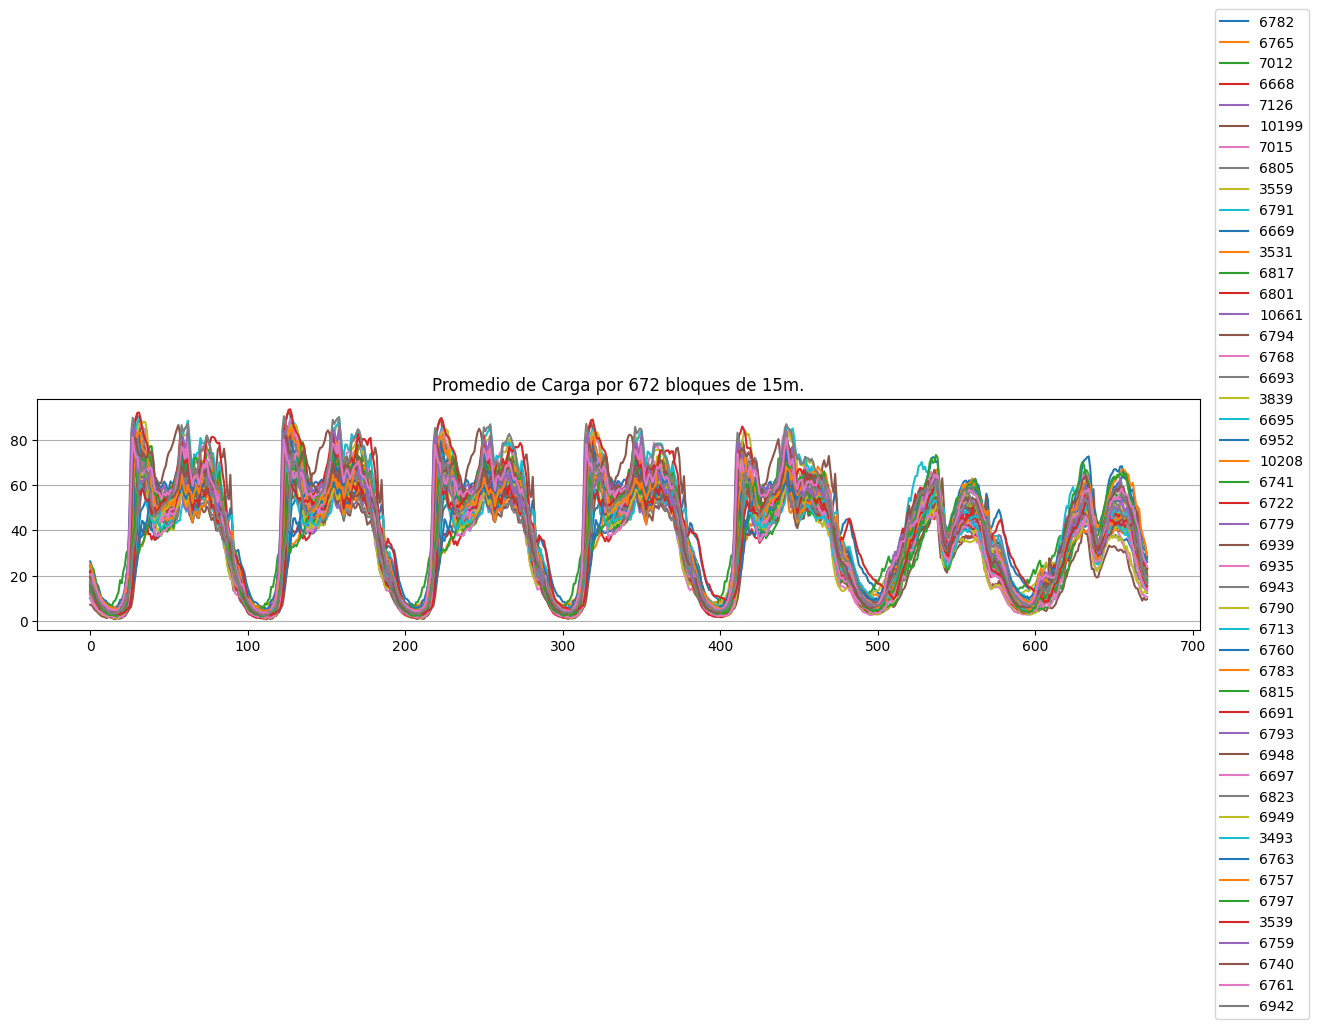

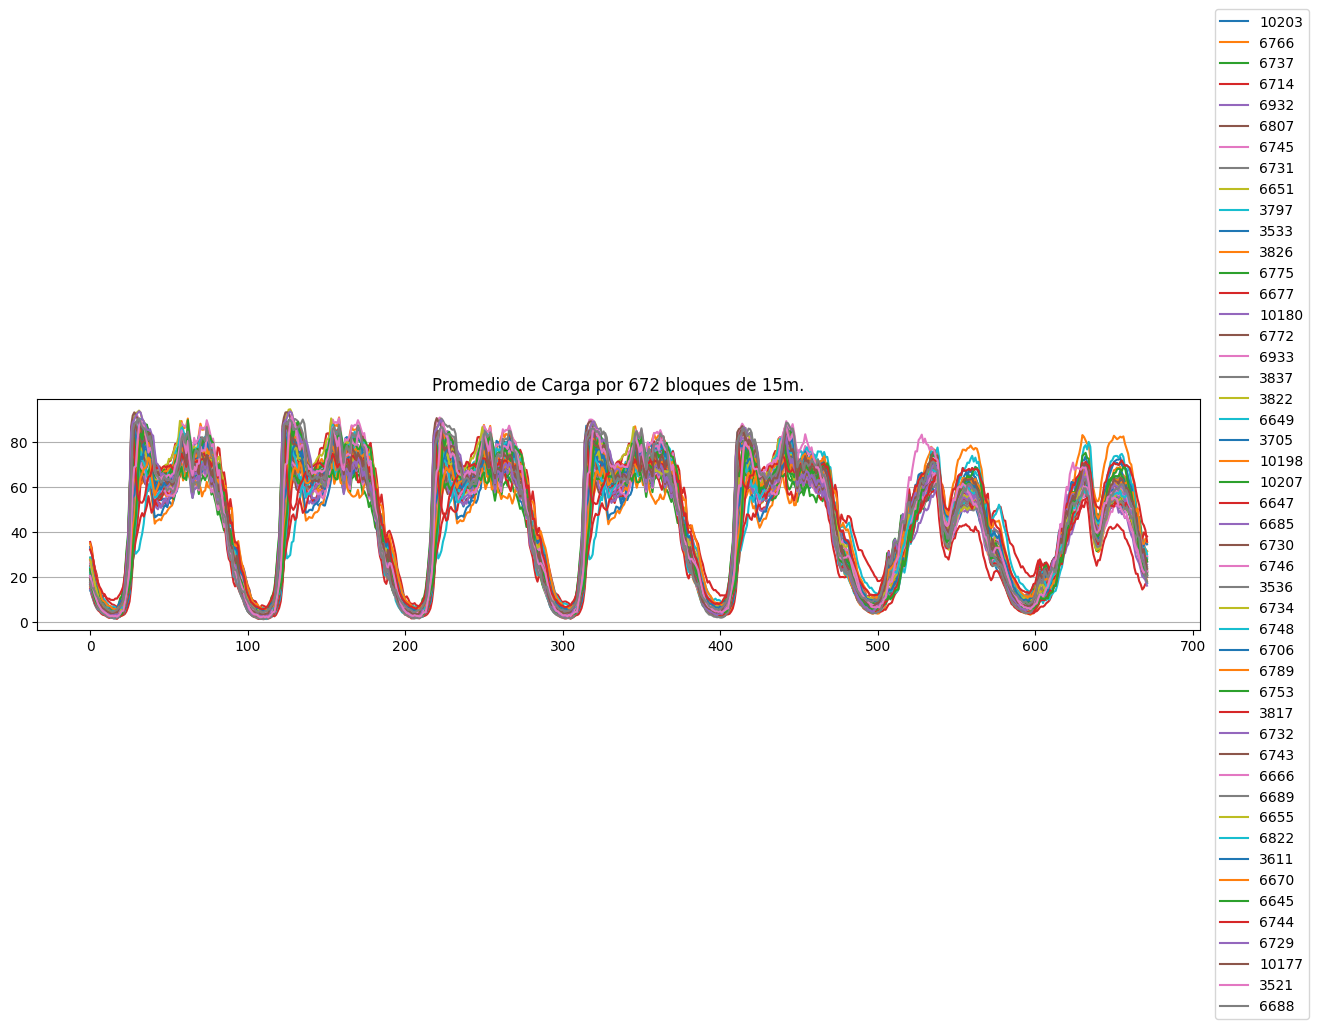

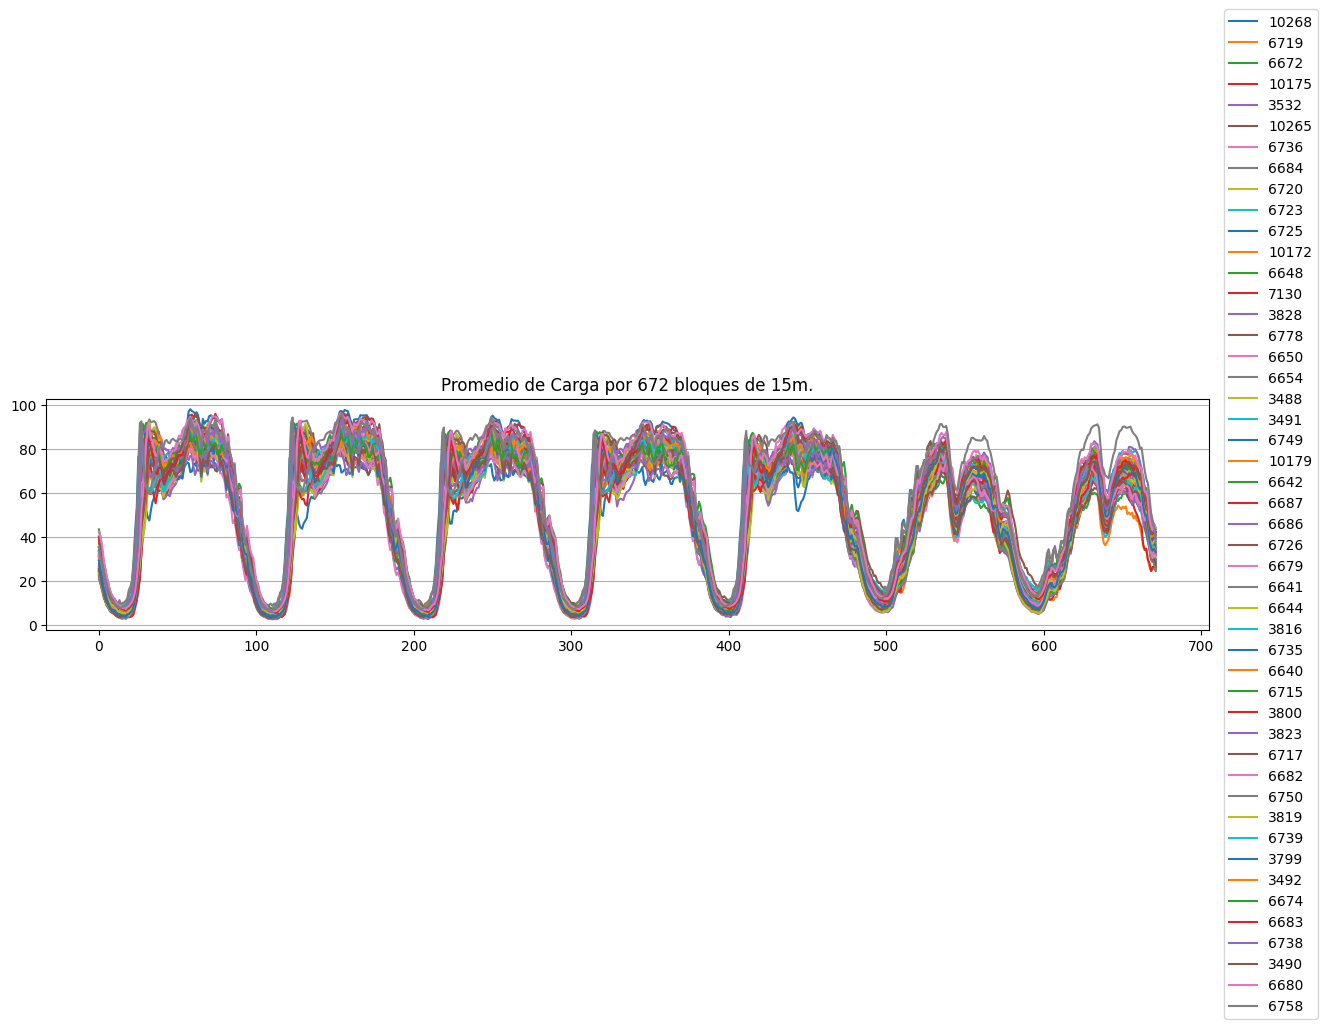

Archivo outputdata_m30_fulldates/m30_2024_ids_por_grupo_carga.txt escrito correctamente.


In [59]:
g1 = []
g2 = []
g3 = []
g4 = []
g5 = []
lgrupos = [g1, g2, g3, g4, g5]
ids_por_grupo = int(len(list_IDs_final) / 5)
print(len(list_IDs_final))
print(ids_por_grupo)
xesimo = 0
for g in lgrupos:
    # Buscar el xesimo elemento
    for x in range(ids_por_grupo):
        buscado = distF[xesimo]
        i = 0
        encontrado = False
        while i < len(list_IDs_final) and not encontrado:
            if m[fmax][i] == buscado:
                g.append(list_IDs_final[i])
                encontrado = True
            i += 1
        xesimo +=1
print(xesimo)
for g in lgrupos:
    graficaPromedioBloquesPorSerie(g, ids_por_grupo, 672)


# Archivo para la construcción de la estructura
nombrearchivo = "outputdata_m30_fulldates/m30_2024_ids_por_grupo_carga.txt"
archivo = open(nombrearchivo,"w")
for ids in lgrupos:
    archivo.write(str(len(ids))+" ")
archivo.write("\n")
for ids in lgrupos:
    for ide in ids:
        archivo.write(str(ide)+" ")
    archivo.write("\n")
archivo.close()
print("Archivo", nombrearchivo, "escrito correctamente.")

In [60]:
posG = 1
temporalListCodes = []
for g in lgrupos:
    temporalCodes = []
    for i in g:
        if i in dicc_IdCod:
            temporalCodes.append(dicc_IdCod[i])
    temporalCodes.sort()
    temporalListCodes.append(temporalCodes)
print("Grupo 1\tGrupo 2\tGrupo 3\tGrupo 4\tGrupo 5")
for i in range(ids_por_grupo):
    for l in temporalListCodes:
        print(l[i], end="\t")
    print("")

# Archivo de lista de vecindad
nombrearchivo = "outputdata_m30_fulldates/m30_2024_listaVecindad_carga_por_grupos.txt"
archivo = open(nombrearchivo,"w")
archivo.write(str(len(list_Cods_final)) + "\n")
for ids in lgrupos:
    for ide in ids:
        archivo.write(str(ide)+" ")
archivo.write("\n")
for ids in lgrupos:
    tope = len(ids)
    for i in range(tope):
        archivo.write(str(ids[i]) + " 1 " + str(ids[i-1]) + "\n")
archivo.close()
print("Archivo", nombrearchivo, "escrito correctamente.")

Grupo 1	Grupo 2	Grupo 3	Grupo 4	Grupo 5
PM10092	PM10343	PM10766	PM10142	PM10013	
PM10344	PM10728	PM10768	PM10212	PM10021	
PM10578	PM10764	PM10865	PM10242	PM10091	
PM10907	PM11102	PM12121	PM10342	PM10141	
PM10942	PM12331	PM12241	PM10402	PM10241	
PM10948	PM12342	PM12391	PM10486	PM10341	
PM10985	PM12781	PM12572	PM10711	PM10401	
PM12067	PM13222	PM12622	PM10765	PM10471	
PM12122	PM20025	PM20021	PM10902	PM10472	
PM12397	PM20152	PM20321	PM10982	PM10502	
PM12571	PM20776	PM20596	PM11201	PM10533	
PM12641	PM20778	PM20756	PM11303	PM10611	
PM12721	PM20948	PM20777	PM11981	PM10612	
PM12921	PM22341	PM20854	PM12502	PM10712	
PM13044	PM22391	PM21148	PM13041	PM10832	
PM13221	PM22471	PM21185	PM20026	PM10861	
PM20667	PM22571	PM21188	PM20042	PM10862	
PM20972	PM22641	PM21192	PM20471	PM10901	
PM21236	PM22781	PM21231	PM20472	PM10941	
PM22572	PM22851	PM21301	PM20473	PM10945	
PM22721	PM23221	PM21307	PM20571	PM11071	
PM22901	PM30472	PM22082	PM20661	PM11101	
PM22971	PM30902	PM22241	PM20721	PM11108	
PM23073	PM31264	P

77.82504
64.3569
0.0
56.74747
75.59256
83.99419
43.32366
56.16935
22.51628
88.75303
6702
PM12921


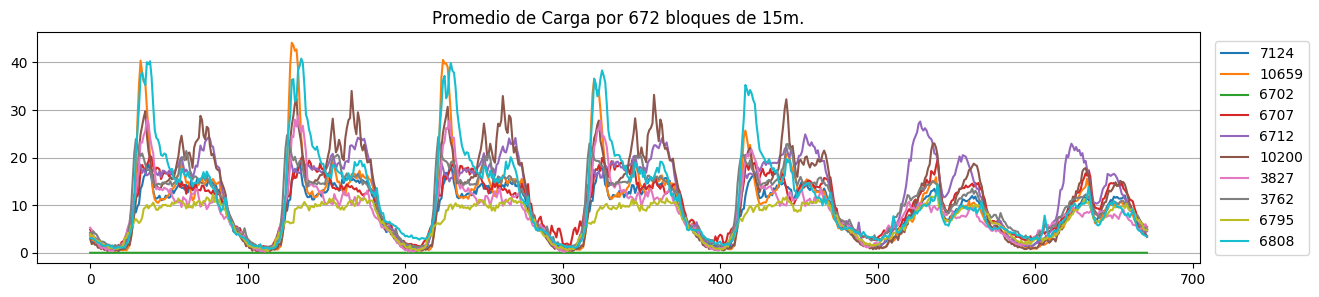

In [61]:
listatemporalIDs = []
for f in range(len(m[fmax])):
    if m[fmax][f] < 100:
        print(m[fmax][f])
        listatemporalIDs.append(list_IDs_final[f])
idfmax = list_IDs_final[fmax]
print(idfmax)
codfmax = dicc_IdCod[idfmax]
print(codfmax)
graficaPromedioBloquesPorSerie(listatemporalIDs, len(listatemporalIDs), 672)

In [62]:
def graficaPromedioBloquesPorSerieEnGrande(listaIDs, numSeriesGrafica, numBloquesGrafica):
    if len(listaIDs) < numSeriesGrafica:
        numSeriesGrafica = len(listaIDs)
    promedio_horas = []
    for ids in listaIDs[:numSeriesGrafica]:
        ph = np.zeros(numBloquesGrafica)
        ps = dicc_posID[ids]
        for p in range(numFechas):
            ph[p%numBloquesGrafica] += grillaCarga[ps][p]
        muestrasXhora = numFechas/numBloquesGrafica
        for p in range(numBloquesGrafica):
            ph[p] = ph[p] / muestrasXhora
        promedio_horas.append(ph)
    plt.figure(figsize=(16,7))
    for s in range(numSeriesGrafica):
        plt.plot(promedio_horas[s], label=str(listaIDs[s])+" ["+dicc_IdCod[listaIDs[s]]+"]")
    plt.title('Promedio de Carga por '+str(numBloquesGrafica)+' bloques de 15m.')
    #plt.savefig('histograma_2024_vecinos_x_distancia.png', bbox_inches='tight')
    plt.grid(axis='y')
    #plt.yscale('log')
    ticks = range(numBloquesGrafica)
    #plt.xticks(ticks)
    plt.legend(loc='center right', bbox_to_anchor=(1.15, 0.5))
    plt.show()
    plt.close()

In [63]:
# Estrategia: utilizar una serie de referencia y un factor que permita reducir los valores
def estrategiaSerieReferenciaYFactor(listaIDs, listaReferencia):
    if len(listaReferencia) != numFechas:
        print("Error! la lista de referencia no es del largo " + str(numFechas))
    diccHistoDO = {}
    diccHistoPR = {}
    factores = []
    for i in listaIDs:
        ps = dicc_posID[i]
        factor = int(sum(grillaCarga[ps]) / sum(listaReferencia))
        factores.append(factor)
        for x in range(numFechas):
            vDO = grillaCarga[ps][x]
            if vDO not in diccHistoDO:
                diccHistoDO[vDO] = 1
            else:
                diccHistoDO[vDO] += 1
            vPR = vDO - (factor * listaReferencia[x])
            if vPR not in diccHistoPR:
                diccHistoPR[vPR] = 1
            else:
                diccHistoPR[vPR] += 1
    listadoDicc = [diccHistoDO, diccHistoPR]
    listadoTitu = ["Datos Originales", "Propuesta Prom + Factor (Carga)"]
    tit = "Histograma Comparación para Datos Originales vs Promedio + Factor (Intensidad)"
    plotHistograma(listadoDicc, listadoTitu, tit)
    print("Factores:", factores)

Valores minimos: [np.int64(0), np.int64(-2087606)]
Valores máximos: [np.int64(100), np.int64(100)]


/home/carlos/venv_python3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


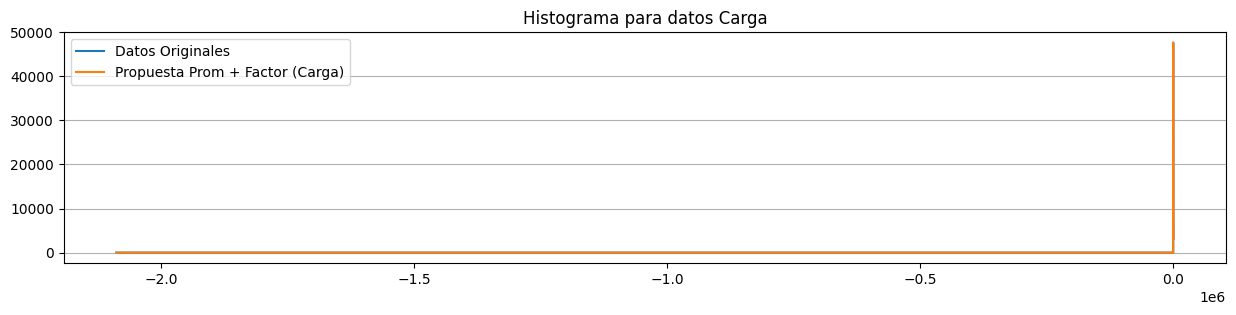

Factores: [1809346, 1780362, 1828556, 1755895, 1752521, 1753786, 1713952, 1901266, 1652284, 1785723, 1850072, 1721336, 1700090, 2087706, 1982410, 1637792, 1836383, 1592990, 1365584, 1271346, 768492, 1245959, 544413, 727046, 578541, 907363, 1, 1618654, 602330]
Valores minimos: [np.int64(0), np.int64(-168)]
Valores máximos: [np.int64(100), np.int64(97)]


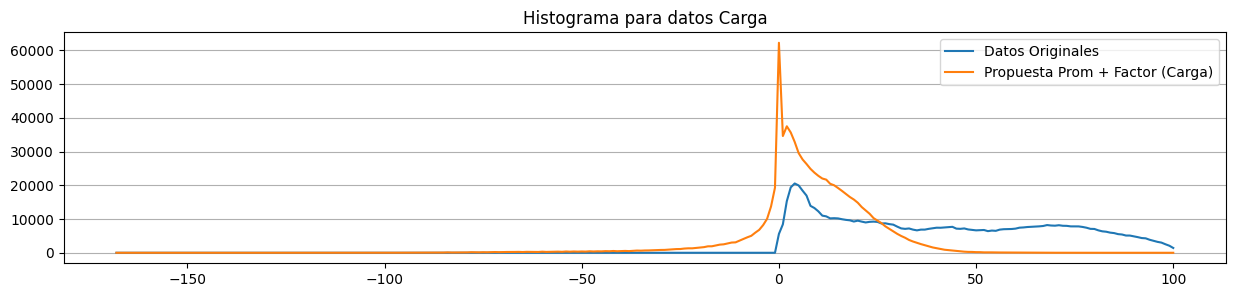

Factores: [1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 1, 2, 1, 1, 1, 2, 2, 2, 3, 1]
Valores minimos: [np.int64(0), np.int64(-153)]
Valores máximos: [np.int64(100), np.int64(100)]


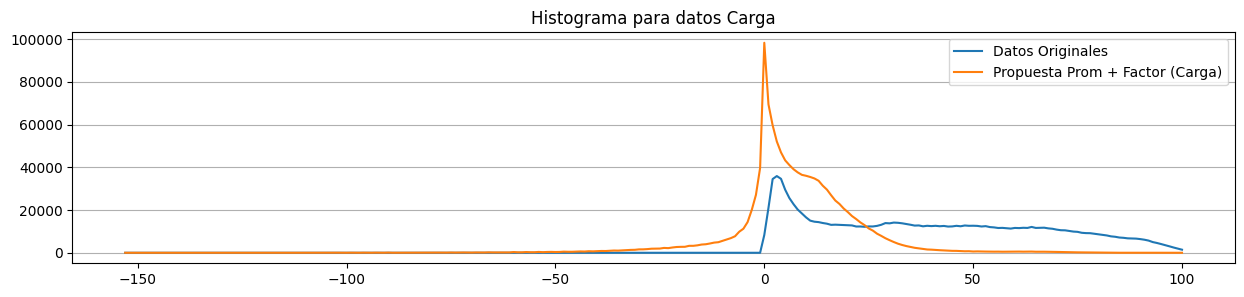

Factores: [2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 4, 2, 2, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2]
Valores minimos: [np.int64(0), np.int64(-138)]
Valores máximos: [np.int64(100), np.int64(100)]


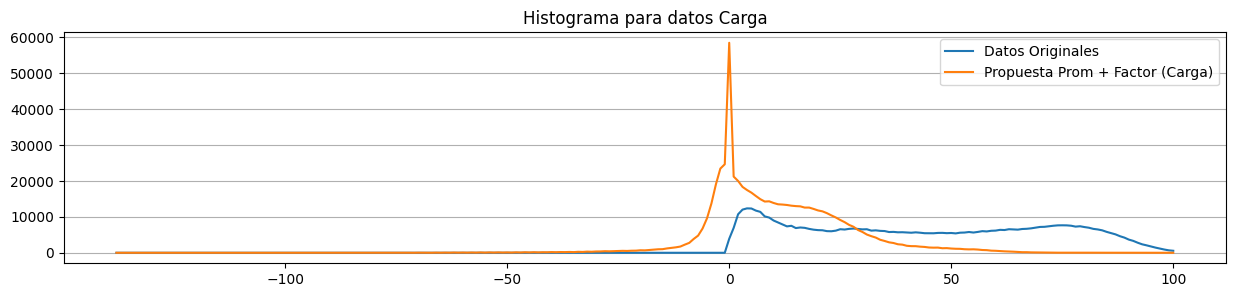

Factores: [1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1]
Valores minimos: [np.int64(0), np.int64(-344)]
Valores máximos: [np.int64(100), np.int64(100)]


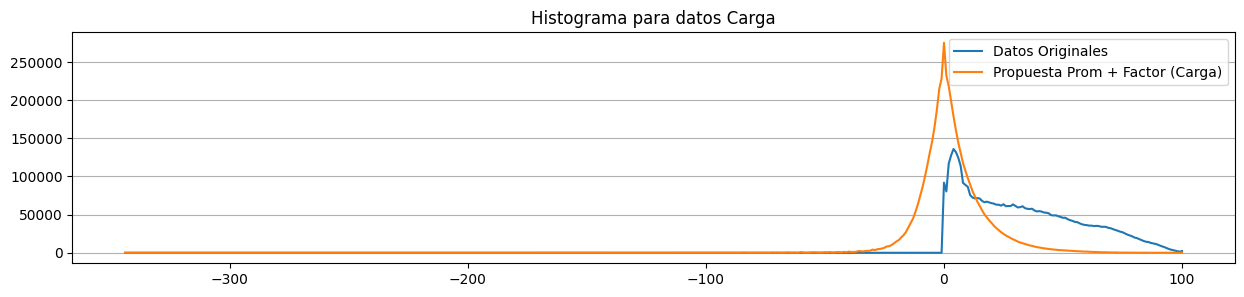

Factores: [7, 3, 2, 6, 7, 3, 4, 4, 6, 5, 4, 5, 2, 8, 1, 3, 7, 7, 7, 6, 2, 1, 1, 4, 6, 6, 6, 5, 7, 3, 6, 4, 5, 4, 6, 4, 6, 6, 4, 9, 6, 6, 5, 2, 5, 3, 6, 1, 6, 6, 6, 4, 3, 2, 3, 2, 4, 5, 4, 4, 7, 5, 6, 4, 3, 5, 5, 1, 5, 3, 3, 4, 3, 5, 3, 3, 6, 2, 6, 6, 1, 3, 4, 3, 6, 4, 4, 5, 4, 1, 7, 6, 5, 3, 4, 6, 7, 2, 3, 6, 3, 1, 2, 3, 2, 6, 6, 5, 2, 5, 4, 4, 1, 4, 5, 5, 3, 5, 2, 3, 5, 3, 3, 2, 4, 2, 3, 4, 4, 4, 4, 6, 1, 6, 4, 4]


In [64]:
# Usando como referencia la lista con la menor suma de valores
for listaIDs in ids_PM_full:
    idMenor = listaIDs[0]
    ps = dicc_posID[idMenor]
    sumMenor = sum(grillaCarga[ps])
    for ide in listaIDs:
        ps = dicc_posID[ide]
        s = sum(grillaCarga[ps])
        if s < sumMenor :
            sumMenor = s
            idMenor = ide
    ps = dicc_posID[idMenor]
    estrategiaSerieReferenciaYFactor(listaIDs, grillaCarga[ps])

0.54775 190 191 10176 6661


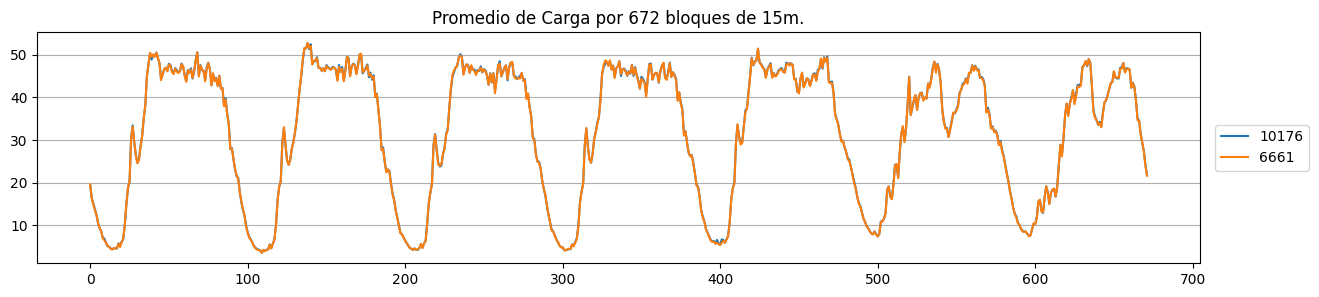

[ 0.       0.54775 19.37533 22.66952 26.11218 31.09748]
Primeros 10
Buscando: 0.0
Encontrado en pos: 190 correspondiente a ID: 10176 con código: PM40462
Buscando: 0.54775
Encontrado en pos: 191 correspondiente a ID: 6661 con código: PM40463
Buscando: 19.37533
Encontrado en pos: 104 correspondiente a ID: 10267 con código: PM20778
Buscando: 22.66952
Encontrado en pos: 126 correspondiente a ID: 6765 con código: PM21301
Buscando: 26.11218
Encontrado en pos: 115 correspondiente a ID: 10178 con código: PM20948
Buscando: 31.09748
Encontrado en pos: 25 correspondiente a ID: 3489 con código: PM10728
Buscando: 31.70555
Encontrado en pos: 149 correspondiente a ID: 6934 con código: PM23221
Buscando: 31.72618
Encontrado en pos: 161 correspondiente a ID: 3838 con código: PM30902
Buscando: 33.36151
Encontrado en pos: 45 correspondiente a ID: 6681 con código: PM11102
Buscando: 38.43059
Encontrado en pos: 76 correspondiente a ID: 3821 con código: PM20025
10176	6661	10267	6765	10178	3489	6934	3838	6681	

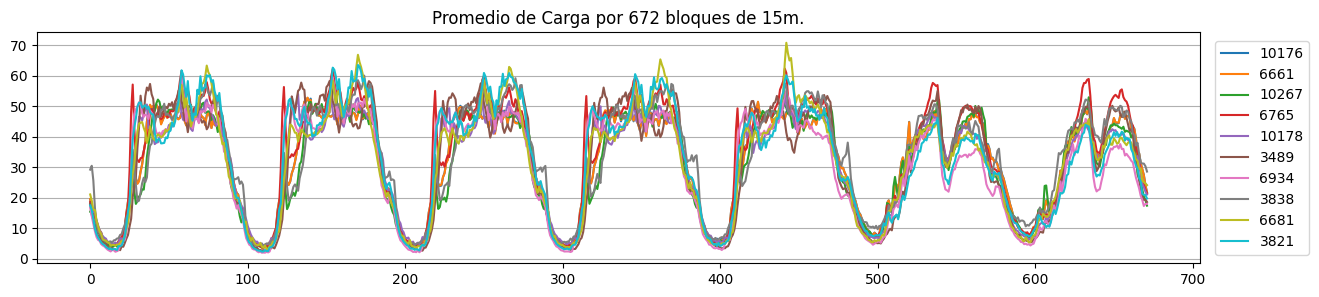

Ultimos 10
Buscando: 459.67976
Encontrado en pos: 69 correspondiente a ID: 6702 con código: PM12921
Buscando: 405.56123
Encontrado en pos: 118 correspondiente a ID: 6755 con código: PM20976
Buscando: 387.8856
Encontrado en pos: 120 correspondiente a ID: 6758 con código: PM21181
Buscando: 370.43081
Encontrado en pos: 44 correspondiente a ID: 6680 con código: PM11101
Buscando: 342.12295
Encontrado en pos: 43 correspondiente a ID: 6679 con código: PM11071
Buscando: 323.78839
Encontrado en pos: 47 correspondiente a ID: 6683 con código: PM11161
Buscando: 319.88403
Encontrado en pos: 30 correspondiente a ID: 3490 con código: PM10832
Buscando: 318.84491
Encontrado en pos: 39 correspondiente a ID: 6674 con código: PM10945
Buscando: 309.62289
Encontrado en pos: 32 correspondiente a ID: 3492 con código: PM10862
Buscando: 301.76837
Encontrado en pos: 99 correspondiente a ID: 6738 con código: PM20722
6702	6755	6758	6680	6679	6683	3490	6674	3492	6738	


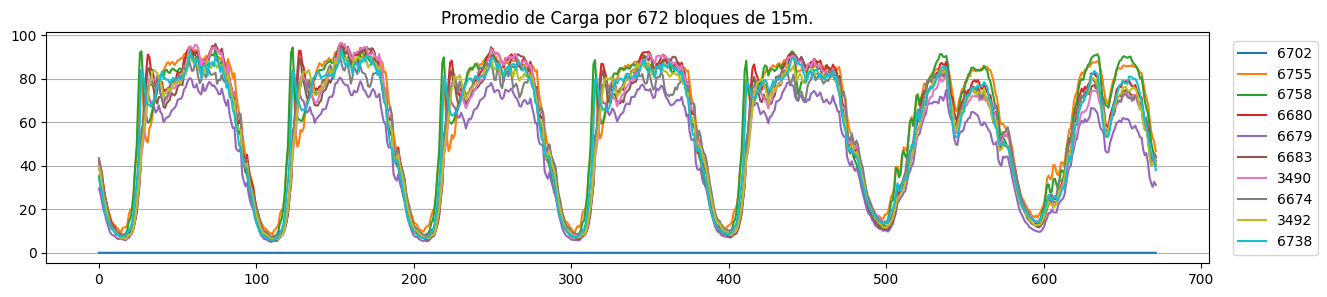

In [65]:
minmatriz = m[0][1]
fmin = [0]
cmin = [1]
for f in range(len(m)):
    for c in range(len(m[f])):
        if m[f][c] < minmatriz and m[f][c] != 0:
            minmatriz = m[f][c]
            fmin = f
            cmin = c
print(minmatriz, fmin, cmin, list_IDs_final[fmin], list_IDs_final[cmin])
graficaPromedioBloquesPorSerie([list_IDs_final[fmin], list_IDs_final[cmin]], 2, 672)
filaMenor = m[fmin].copy()
filaMenor.sort()
print(filaMenor[:6])
print("Primeros 10")
listaIDsMasParecidos = []
for i in range(10):
    busca = filaMenor[i]
    print("Buscando:", busca)
    j = 0
    while j<len(m) and m[fmin][j] != busca:
        j+= 1
    print("Encontrado en pos:", j, "correspondiente a ID:", list_IDs_final[j], "con código:", dicc_IdCod[list_IDs_final[j]])
    listaIDsMasParecidos.append(int(list_IDs_final[j]))
for i in listaIDsMasParecidos:
    print(i, end="\t")
print("")
graficaPromedioBloquesPorSerie(listaIDsMasParecidos, len(listaIDsMasParecidos), 672)
print("Ultimos 10")
listaIDsMasParecidos = []
for i in range(10):
    busca = filaMenor[len(list_IDs_final) - i - 1]
    print("Buscando:", busca)
    j = 0
    while j<len(m) and m[fmin][j] != busca:
        j+= 1
    print("Encontrado en pos:", j, "correspondiente a ID:", list_IDs_final[j], "con código:", dicc_IdCod[list_IDs_final[j]])
    listaIDsMasParecidos.append(int(list_IDs_final[j]))
for i in listaIDsMasParecidos:
    print(i, end="\t")
print("")
graficaPromedioBloquesPorSerie(listaIDsMasParecidos, len(listaIDsMasParecidos), 672)

In [66]:
# Calculando listas de vecindad por distancia
from geopy import distance

In [67]:
# Versión: vecinos por distancia menor a umbral
dist0050 = []
dist0100 = []
dist0150 = []
dist0250 = []
dist0500 = []
dist0750 = []
dist1000 = []
print("Calculando vecinos con distintas distancias")
matrizDistanciasKm = np.zeros((cantSensFinal,cantSensFinal))
for x in range(0,cantSensFinal):
    idx = list_IDs_final[x]
    cooX = (dicc_IdLatLon[idx][0][0], dicc_IdLatLon[idx][0][1])
    temDist0050 = 0
    temDist0100 = 0
    temDist0150 = 0
    temDist0250 = 0
    temDist0500 = 0
    temDist0750 = 0
    temDist1000 = 0
    for y in range(0,cantSensFinal):
        if x != y:
            idy = list_IDs_final[y]
            cooY = (dicc_IdLatLon[idy][0][0], dicc_IdLatLon[idy][0][1])
            dKm = distance.distance(cooX, cooY).km
            matrizDistanciasKm[x][y] = dKm
            if dKm <= 1 :
                temDist1000 += 1
            if dKm <= 0.75:
                temDist0750 += 1
            if dKm <= 0.5:
                temDist0500 += 1
            if dKm <= 0.25:
                temDist0250 += 1
            if dKm <= 0.15:
                temDist0150 += 1
            if dKm <= 0.1:
                temDist0100 += 1
            if dKm <= 0.05:
                temDist0050 += 1
        else:
            matrizDistanciasKm[x][y] = 0.0
    dist0050.append(temDist0050)
    dist0100.append(temDist0100)
    dist0150.append(temDist0150)
    dist0250.append(temDist0250)
    dist0500.append(temDist0500)
    dist0750.append(temDist0750)
    dist1000.append(temDist1000)
print("Listo")

Calculando vecinos con distintas distancias
Listo


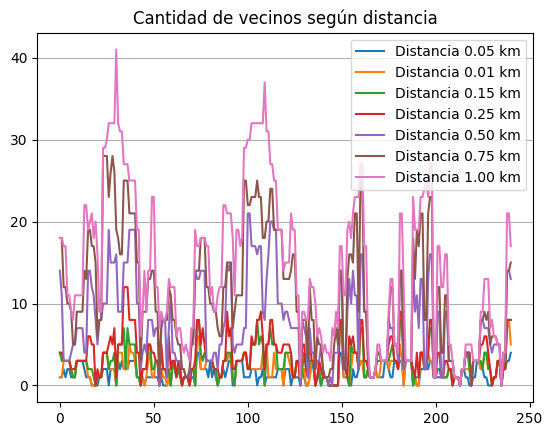

In [68]:
plt.plot(dist0050, label='Distancia 0.05 km')
plt.plot(dist0100, label='Distancia 0.01 km')
plt.plot(dist0150, label='Distancia 0.15 km')
plt.plot(dist0250, label='Distancia 0.25 km')
plt.plot(dist0500, label='Distancia 0.50 km')
plt.plot(dist0750, label='Distancia 0.75 km')
plt.plot(dist1000, label='Distancia 1.00 km')
plt.title("Cantidad de vecinos según distancia")
#plt.savefig('images/histograma_vecinos_x_distncia.png', bbox_inches='tight')
plt.grid(axis='y')
#plt.yscale('log')
plt.legend()
plt.show()
plt.close()

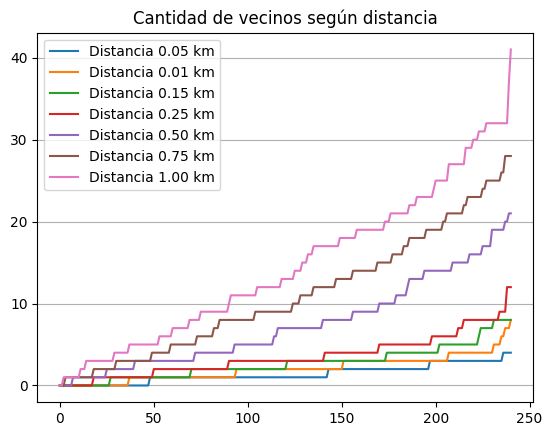

In [69]:
dist0050.sort()
dist0100.sort()
dist0150.sort()
dist0250.sort()
dist0500.sort()
dist0750.sort()
dist1000.sort()
plt.plot(dist0050, label='Distancia 0.05 km')
plt.plot(dist0100, label='Distancia 0.01 km')
plt.plot(dist0150, label='Distancia 0.15 km')
plt.plot(dist0250, label='Distancia 0.25 km')
plt.plot(dist0500, label='Distancia 0.50 km')
plt.plot(dist0750, label='Distancia 0.75 km')
plt.plot(dist1000, label='Distancia 1.00 km')
plt.title("Cantidad de vecinos según distancia")
#plt.savefig('images/histograma_vecinos_x_distncia.png', bbox_inches='tight')
plt.grid(axis='y')
#plt.yscale('log')
plt.legend()
plt.show()
plt.close()

In [70]:
print(matrizDistanciasKm)
print("Generando diccionario con vecinos de 50, 100, 150 y 250 metros.")
dicc_vec_dist_0050 = {}
dicc_vec_dist_0100 = {}
dicc_vec_dist_0150 = {}
dicc_vec_dist_0250 = {}
for x in range(0,cantSensFinal):
    temVec0050 = []
    temVec0100 = []
    temVec0150 = []
    temVec0250 = []
    for y in range(0,cantSensFinal):
        if x != y:
            if matrizDistanciasKm[x][y] <= 0.05:
                temVec0050.append(list_IDs_final[y])
            if matrizDistanciasKm[x][y] <= 0.1:
                temVec0100.append(list_IDs_final[y])
            if matrizDistanciasKm[x][y] <= 0.15:
                temVec0150.append(list_IDs_final[y])
            if matrizDistanciasKm[x][y] <= 0.25:
                temVec0250.append(list_IDs_final[y])
    if len(temVec0050) > 0:
        dicc_vec_dist_0050[list_IDs_final[x]] = temVec0050
    if len(temVec0100) > 0:
        dicc_vec_dist_0100[list_IDs_final[x]] = temVec0100
    if len(temVec0150) > 0:
        dicc_vec_dist_0150[list_IDs_final[x]] = temVec0150
    if len(temVec0250) > 0:
        dicc_vec_dist_0250[list_IDs_final[x]] = temVec0250

# Comprobando coincidencia en el largo de la lista de vecinos
for i in range(5):
    tempID = list_IDs_final[i]
    print("Elemento", i, "con id:", tempID)
    print("050m:", dist0050[i], len(dicc_vec_dist_0050[tempID]), dicc_vec_dist_0050[tempID])
    print("100m:", dist0100[i], len(dicc_vec_dist_0100[tempID]), dicc_vec_dist_0100[tempID])
    print("150m:", dist0150[i], len(dicc_vec_dist_0150[tempID]), dicc_vec_dist_0150[tempID])
    print("250m:", dist0250[i], len(dicc_vec_dist_0250[tempID]), dicc_vec_dist_0250[tempID])

[[0.         0.03509579 0.55316363 ... 0.38901137 0.39507263 0.48652983]
 [0.03509579 0.         0.51866324 ... 0.41843075 0.4246481  0.51684383]
 [0.55316363 0.51866324 0.         ... 0.92189073 0.92861506 1.02226484]
 ...
 [0.38901137 0.41843075 0.92189073 ... 0.         0.00698894 0.10039282]
 [0.39507263 0.4246481  0.92861506 ... 0.00698894 0.         0.0936498 ]
 [0.48652983 0.51684383 1.02226484 ... 0.10039282 0.0936498  0.        ]]
Generando diccionario con vecinos de 50, 100, 150 y 250 metros.
Elemento 0 con id: 6640
050m: 0 1 [np.int64(6641)]
100m: 0 1 [np.int64(6641)]
150m: 0 4 [np.int64(6641), np.int64(6713), np.int64(3821), np.int64(3822)]
250m: 0 4 [np.int64(6641), np.int64(6713), np.int64(3821), np.int64(3822)]
Elemento 1 con id: 6641
050m: 0 1 [np.int64(6640)]
100m: 0 1 [np.int64(6640)]
150m: 0 3 [np.int64(6640), np.int64(6713), np.int64(3822)]
250m: 0 4 [np.int64(6640), np.int64(6713), np.int64(3821), np.int64(3822)]
Elemento 2 con id: 6642
050m: 0 2 [np.int64(6643), n

In [71]:
print(len(dicc_vec_dist_0050))
print(len(dicc_vec_dist_0100))
print(len(dicc_vec_dist_0150))
print(len(dicc_vec_dist_0250))

193
204
214
223


In [72]:
exportarArchivoVecinos(dicc_vec_dist_0050, "outputdata_m30_fulldates/m30_2024_listavecinos_050m_carga.txt")
exportarArchivoVecinos(dicc_vec_dist_0100, "outputdata_m30_fulldates/m30_2024_listavecinos_100m_carga.txt")
exportarArchivoVecinos(dicc_vec_dist_0150, "outputdata_m30_fulldates/m30_2024_listavecinos_150m_carga.txt")
exportarArchivoVecinos(dicc_vec_dist_0250, "outputdata_m30_fulldates/m30_2024_listavecinos_250m_carga.txt")

Archivo outputdata_m30_fulldates/m30_2024_listavecinos_050m_carga.txt escrito correctamente.
Archivo outputdata_m30_fulldates/m30_2024_listavecinos_100m_carga.txt escrito correctamente.
Archivo outputdata_m30_fulldates/m30_2024_listavecinos_150m_carga.txt escrito correctamente.
Archivo outputdata_m30_fulldates/m30_2024_listavecinos_250m_carga.txt escrito correctamente.


In [73]:
# Generando lista de vecinos donde cada sensor se relaciona con los 2 más cercanos a él.
dicc2vecinosmasproximos = {}
for x in range(cantSensFinal):
    idX = list_IDs_final[x]
    dosmascerca = []
    for y in range(cantSensFinal):
        dxy = matrizDistanciasKm[x][y]
        if dxy > 0:
            if len(dosmascerca) < 2:
                dosmascerca.append(dxy)
            else:
                if dxy < max(dosmascerca):
                    dosmascerca = [min(dosmascerca),dxy]
    idsvecinostemp = []
    for y in range(cantSensFinal):
        if matrizDistanciasKm[x][y] == dosmascerca[0] or matrizDistanciasKm[x][y] == dosmascerca[1]:
            idsvecinostemp.append(int(list_IDs_final[y]))
    dicc2vecinosmasproximos[idX] = idsvecinostemp
    if len(idsvecinostemp) > 2:
        print("Warning! lista con", len(idsvecinostemp), "elementos.")
print("Sensores con los 2 vecinos más cerca:", len(dicc2vecinosmasproximos))
exportarArchivoVecinos(dicc2vecinosmasproximos, "outputdata_m30_fulldates/m30_2024_listavecinos_2masproximos_carga.txt")

Sensores con los 2 vecinos más cerca: 241
Archivo outputdata_m30_fulldates/m30_2024_listavecinos_2masproximos_carga.txt escrito correctamente.
